In [1]:
import argparse
import os
import sys
import datetime
import time
import math
import json
from pathlib import Path
import yaml
from collections import defaultdict, Counter
import random
from functools import partial

from sklearn.metrics import confusion_matrix
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from  torch.utils.data import DataLoader
import torch.distributed as dist
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision import models as torchvision_models
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.manifold import TSNE
import umap
from torchvision.models.resnet import BasicBlock, Bottleneck
from torch import Tensor

import utils
import vision_transformer as vits
from vision_transformer import DINOHead, VisionTransformer

from main_dino import DataAugmentationDINO , DINOLoss, train_one_epoch
from dino_emb import DataAugmentationDINOMNIST
from my_utils import ResNetMNIST, plot_embed, DINOLoss, train_one_epoch, load_pretrained_backbone_head, CustomWrapper, converge_cosine_scheduler, \
    DataAugmentationDINOCIFAR10, myResNet, DataAugmentationDINOSVHN, ReturnEmbWrapper, Smallscale_DataAugmentationDINOSVHN
if "../" not in sys.path:
    sys.path.append("../")
from dataloaders import load

from importlib import import_module, reload

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


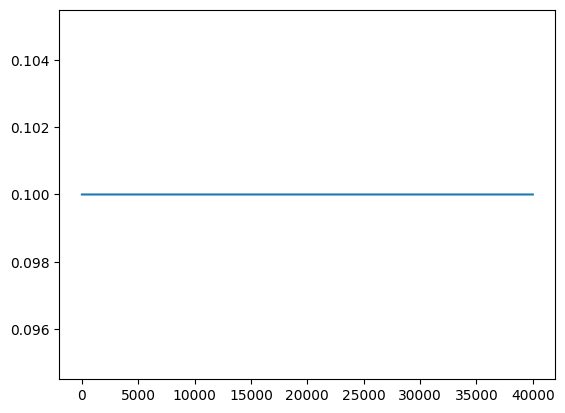

In [3]:
plt.plot(converge_cosine_scheduler(0.1, 0.1,
400, 100,
start_warmup_value=0.1,
warmup_epochs=200,
converge_epoch= 400))

In [16]:
import timm
# timm_resnet18 = timm.create_model('resnet18', pretrained=False, num_classes=128)
timm_resnet18 = timm.models.resnet.ResNet(timm.models.resnet.BasicBlock, [2,2,2,2], num_classes=128, drop_rate=0.2)
timm_efficientnetv2 = timm.create_model("efficientnetv2_s", pretrained=False, num_classes=128) 


In [18]:
timm_efficientnetv2.classifier

Linear(in_features=1280, out_features=128, bias=True)

In [22]:
timm_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [19]:
class Normalize_Module(nn.Module):
    def __init__(self, p=2, dim=1):
        super(Normalize_Module, self).__init__()
        self.p = p
        self.dim = dim

    def forward(self, x):
        return torch.nn.functional.normalize(x, p=self.p, dim=self.dim)

timm_resnet18.fc = nn.Sequential(
            timm_resnet18.fc,
            Normalize_Module(p=2, dim=1)
)

timm_efficientnetv2.classifier = nn.Sequential(
            timm_efficientnetv2.classifier,
            Normalize_Module(p=2, dim=1)
)

In [21]:
timm_efficientnetv2(torch.rand(10,3,32,32)).norm(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], grad_fn=<LinalgVectorNormBackward0>)

In [16]:
import umap
_umap = umap.UMAP()
array=(np.random.rand(20000,128)-0.5)/100
umap_array = _umap.fit_transform(array)

In [121]:
from importlib import import_module, reload
reload(sys.modules["my_utils"])
reload(sys.modules["dataloaders"])

<module 'dataloaders' from '/workspace/puae/dino/../dataloaders.py'>

In [491]:
torchvision_models.ResNet._forward_impl

<function torchvision.models.resnet.ResNet._forward_impl(self, x: torch.Tensor) -> torch.Tensor>

In [56]:
# class myResNet(torchvision_models.ResNet):
#     def __init__(self, block, layers, num_classes = 1000, zero_init_residual = False, groups = 1, width_per_group = 64, replace_stride_with_dilation = None, norm_layer = None):
#         super().__init__(block, layers, num_classes, zero_init_residual, groups, width_per_group, replace_stride_with_dilation, norm_layer)
    
#     def _forward_impl(self, x: Tensor) -> Tensor:
#         # See note [TorchScript super()]
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)
#         x = torch.nn.functional.normalize(x, dim=1)

#         return x
# test_model = myResNet(BasicBlock, [2,2,2,2])
# test_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)
# test_model.fc = nn.Linear(test_model.fc.in_features, out_features=10, bias=True)
# test_model(torch.randn(10,1,112,112)).norm(dim=1)

In [502]:
class args(object):
    def __init__(self):
        pass
my_arg = args()
my_arg.port = "29500"
my_arg.dist_url = "env://"
utils.init_distributed_mode(my_arg)

Will run the code on one GPU.
| distributed init (rank 0): env://


In [506]:
last_layer = nn.utils.weight_norm(nn.Linear(128, 100, bias=False)).cuda()
last_layer.weight_g.data.fill_(1)
last_layer.weight_g.requires_grad = False
# nn.parallel.DistributedDataParallel(last_layer, device_ids=[0], broadcast_buffers=False)


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [513]:
state_repr_vec = torch.load("/workspace/puae/dino/outputs/test/emb_loss_2/checkpoints/checkpoint.pth", map_location="cpu")["t_repr_vec"]
last_layer.load_state_dict(state_repr_vec)
# state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

<All keys matched successfully>

In [76]:
class Random_delate(object):
    """
    Apply Solarization to the PIL image.
    """
    def __init__(self, p):
        self.p = p
        self.kernel = np.ones((3, 3), np.uint8)

    def __call__(self, img):
        if random.random() < self.p:
            return Image.fromarray(cv2.dilate(np.array(img), self.kernel, iterations=1))
        else:
            return img

class DataAugmentationDINOSVHN(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        # CIFAR10に適した基本的な変換
        flip_and_color_jitter = transforms.Compose([
            # transforms.RandomHorizontalFlip(p=0.5),
            # transforms.RandomRotation(degrees=15), 
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomInvert(p=0.2),
            transforms.RandomGrayscale(p=0.2),
        ])
        
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4377, 0.4438, 0.4728), (0.198, 0.201, 0.197)),
        ])

        # first global crop
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(1.0),
            # normalize,
        ])
        
        # second global crop
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(32, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(0.1),
            utils.Solarization(0.2),
            # normalize,
        ])
        
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(24, scale=local_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(p=0.5),
            # normalize,
        ])

    def __call__(self, image):
        crops = []
        # image = image.resize((28, 28))
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        crops.append(image)
        return crops

global_crops_scale: [0.4, 1.0]
local_crops_number: 8
local_crops_scale: [0.05, 0.4]
transform = DataAugmentationDINOSVHN(
        global_crops_scale=[0.8, 1.0],
        local_crops_scale=[0.4, 0.8],
        local_crops_number=8,
    )
transform.__dict__

{'global_transfo1': Compose(
     RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic, antialias=True)
     Compose(
     RandomApply(
     p=0.8
     ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
 )
     RandomInvert(p=0.2)
     RandomGrayscale(p=0.2)
 )
 ),
 'global_transfo2': Compose(
     RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bicubic, antialias=True)
     Compose(
     RandomApply(
     p=0.8
     ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
 )
     RandomInvert(p=0.2)
     RandomGrayscale(p=0.2)
 )
 ),
 'local_crops_number': 8,
 'local_transfo': Compose(
     RandomResizedCrop(size=(24, 24), scale=(0.4, 0.8), ratio=(0.75, 1.3333), interpolation=bicubic, antialias=True)
     Compose(
     RandomApply(
     p=0.8
     ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.8, 1.2

In [77]:
batch_size=256

dataset = datasets.CIFAR10(
            root="../datasets/CIFAR10", download=False, train=True, transform=transform
        )
# dataset = datasets.SVHN(
#             root="../datasets/SVHN", download=False, split="test", transform=transform
#         )

# sampler = torch.utils.data.DistributedSampler(dataset, shuffle=True)
data_loader = torch.utils.data.DataLoader(
    dataset,
    # sampler=sampler,
    shuffle=False,
    batch_size=batch_size,
    num_workers=8,
    pin_memory=True,
    drop_last=True,
)
print(f"Data loaded: there are {len(dataset)} images.")

Data loaded: there are 50000 images.


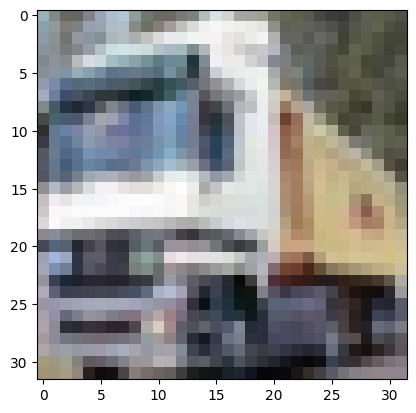

In [79]:
plt.imshow(dataset.__getitem__(1)[0][-1])

3


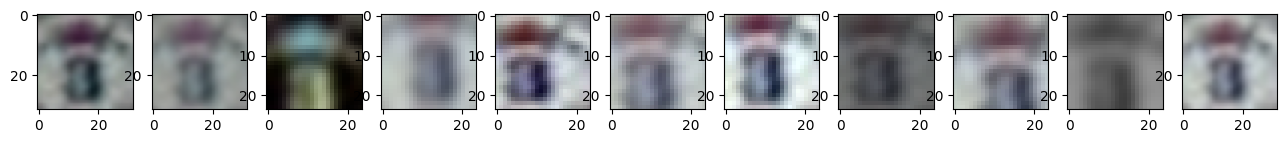

In [303]:
plt.figure(figsize=(16,9))
k = random.randint(0,len(dataset))
for i in range(11):
    plt.subplot(1,11,i+1)
    plt.imshow(dataset.__getitem__(k)[0][i])
print(dataset.__getitem__(k)[1])

In [10]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(residual)
        out = self.relu(out)

        return out

class ResNetMNIST(nn.Module):
    def __init__(self, block=BasicBlock, num_blocks=[2, 2, 2, 2], num_classes=10):
        super(ResNetMNIST, self).__init__()
        self.in_channels = 64
        
        # 最初の畳み込み層を小さくする（7x7→3x3）
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        # プーリング層を削除（画像サイズが小さいため）
        
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)    # 28x28 -> 28x28
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)   # 28x28 -> 28x28
        x = self.layer2(x)   # 28x28 -> 14x14
        x = self.layer3(x)   # 14x14 -> 7x7
        x = self.layer4(x)   # 7x7 -> 4x4
        
        x = self.avgpool(x)  # 4x4 -> 1x1
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x


embed_dim = 2
student = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=embed_dim)
teacher = ResNetMNIST(BasicBlock, [2, 2, 2, 2], num_classes=embed_dim)
# student(torch.Tensor(10,1,28,28))

In [21]:
out_dim=2000
arcface_family_conf = {'name': 'arcface', 's':30.0, 'm':0.20, 'easy_margin':False, 'warmup':10}
arcface_family_conf = {'name': None}

s_head = DINOHead(
        2,
        out_dim=out_dim,
        use_bn=False,
        norm_last_layer=True,
        nlayers=1, #embed_dim->hidden_dim->*->bottleneck_dim->out_dim
        hidden_dim=512,
        bottleneck_dim=512,
        arcface_family_conf=arcface_family_conf
    )

t_head = DINOHead(
        2,
        out_dim=out_dim,
        use_bn=False,
        norm_last_layer=True,
        nlayers=1, #embed_dim->hidden_dim->*->bottleneck_dim->out_dim
        hidden_dim=512,
        bottleneck_dim=512,
        arcface_family_conf=arcface_family_conf
    )


# student(torch.Tensor(10,1,28,28)).shape

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [11]:
sample = data_loader.__iter__().__next__()[0]
sample[2].shape #10*(256*(1*28*28))

torch.Size([256, 1, 21, 21])

In [20]:
glo_t_out = teacher(torch.cat(sample[:2])) #512*2 (2*256*2)
glo_s_out = student(torch.cat(sample[:2])) #512*2 (2*256*2)
loc_s_out = student(torch.cat(sample[2:])) #2048*2 (8*256*2)
t_out = glo_t_out
s_out = torch.cat((glo_s_out, loc_s_out))
t_out.shape, s_out.shape

(torch.Size([512, 2]), torch.Size([2560, 2]))

In [22]:
s_head_out = s_head(s_out)
t_head_out = t_head(t_out)
t_head_out.shape, s_head_out.shape

(torch.Size([512, 2000]), torch.Size([2560, 2000]))

In [47]:
bs=5
global_view=2
local_view=8
total_view=global_view+local_view
out_logit_dim=13


teacher_head_out=torch.ones((bs*global_view,out_logit_dim))
student_head_out=torch.ones((bs*total_view,out_logit_dim))

teacher_head_out[:bs, 0]*=2
teacher_head_out[bs:, 1]*=3

teacher_head_out.shape, student_head_out.shape

(torch.Size([10, 13]), torch.Size([50, 13]))

In [48]:
teacher_head_out

tensor([[2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [49]:
_, max_id = _arcface_layer(teacher_head_out, "teacher")
max_id

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [50]:
student_arcface_out = _arcface_layer(student_head_out, "student", max_id)
student_arcface_out

tensor([[ 1., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [ 1., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [10., 10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [10., 10.,  1.,  

In [41]:
def _multiview_scatter(one_hot, max_id):
        # breakpoint()
        global_view_count=2
        total_view=10
        batch_size=int(len(max_id)/global_view_count)
        for i in range(total_view):
            if i == 0:
                one_hot[list(range(batch_size)), max_id[batch_size:]]=1
            elif i==1:
                one_hot[list(range(batch_size, 2*batch_size)), max_id[:batch_size]]=1
            else:
                one_hot[list(range(i*batch_size, (i+1)*batch_size)), max_id[:batch_size]]=1
                one_hot[list(range(i*batch_size, (i+1)*batch_size)), max_id[batch_size:]]=1
        return one_hot

def _arcface_layer(cosine, type=False, max_id=False):
    # breakpoint()
    if type=="teacher":
        _, max_indices = torch.max(cosine, dim=1)
        return cosine, max_indices
    # breakpoint()
    dtype = cosine.dtype
    sine = torch.sqrt((1.0 - torch.pow(cosine, 2)).clamp(1e-7, 1))
    phi = cosine * 10
    phi = phi.to(dtype)

    if type=="student":
        one_hot = torch.zeros(cosine.size()) #1000*65536 (10*B)*65536
        # _, max_indices = torch.max(cosine, dim=1)
        one_hot = _multiview_scatter(one_hot, max_id)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) -------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)  # you can use torch.where if your torch.__version__ is 0.4

    return output

In [17]:
import math

margins=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
for i in margins:
    print(f"{i} margin to degree: {math.degrees(i)}")

cos = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
for i in cos:
    print(f"cos={i} => radian={math.acos(i)}, degree={math.degrees(math.acos(i))}")

for c in cos:
    print(f"###############cos({math.acos(c)})={c}###############")
    for m in margins:
        print(f"margin={m}, cos({math.acos(c)} + {m}) = cos({math.degrees(math.acos(c))} + {math.degrees(m)})")
        print(f"= {math.cos(math.acos(c) + m)}")
        print(f"cos({math.acos(c)}) - cos({math.acos(c)} + {m}) = {c - math.cos(math.acos(c) + m)}")
        print("=====================")

0.1 margin to degree: 5.729577951308233
0.2 margin to degree: 11.459155902616466
0.3 margin to degree: 17.188733853924695
0.4 margin to degree: 22.918311805232932
0.5 margin to degree: 28.64788975654116
0.6 margin to degree: 34.37746770784939
cos=1.0 => radian=0.0, degree=0.0
cos=0.9 => radian=0.45102681179626236, degree=25.841932763167126
cos=0.8 => radian=0.6435011087932843, degree=36.86989764584401
cos=0.7 => radian=0.7953988301841436, degree=45.5729959991943
cos=0.6 => radian=0.9272952180016123, degree=53.13010235415599
cos=0.5 => radian=1.0471975511965979, degree=60.00000000000001
cos=0.4 => radian=1.1592794807274085, degree=66.42182152179817
cos=0.3 => radian=1.2661036727794992, degree=72.54239687627792
cos=0.2 => radian=1.369438406004566, degree=78.46304096718453
cos=0.1 => radian=1.4706289056333368, degree=84.26082952273322
cos=0.0 => radian=1.5707963267948966, degree=90.0
###############cos(0.0)=1.0###############
margin=0.1, cos(0.0 + 0.1) = cos(0.0 + 5.729577951308233)
= 0.9

In [3]:
unl_train_subset, pos_train_subset, unl_valtrans_subset, pos_valtrans_subset, val_subset = load(
        name="MNIST",
        batch_size=False,
        normal_class=[1],
        unseen_anomaly=[0],
        labeled_anomaly_class=None, #[2,3,4,5,6,7,8,9], 
        n_train = 4500,
        n_valid = 500,
        # n_test = 2000,
        n_unlabeled_normal = 4500, #n_unlabeled_normal
        n_unlabeled_anomaly = 250, #n_unlabeled_anomaly
        n_labeled_anomaly = 250, #n_labeled_anomaly
        return_extra_test_loader= False,
        return_subset=False,
        return_unl_pos_subset=False,
        return_unl_pos_val_subset = False,
        return_pu_pos_tra_valtrans_val_subset = True, 
        transform = None,
        seed=0, 
        return_id = True
        )

5000
4500


In [2]:
test_dataset = load("SVHN", normal_class=[3], unseen_anomaly=[0],return_test_subset=True, seed=0, return_id = True)

Using downloaded and verified file: /workspace/puae/datasets/SVHN/train_32x32.mat
Using downloaded and verified file: /workspace/puae/datasets/SVHN/test_32x32.mat
Using downloaded and verified file: /workspace/puae/datasets/SVHN/train_32x32.mat
tensor([3, 3, 3,  ..., 3, 3, 3])


In [27]:
targets=[]
for _,t in test_dataset:
    targets.append(t)
Counter(targets)

Counter({3: 1000,
         1: 220,
         2: 164,
         5: 121,
         4: 109,
         6: 83,
         8: 81,
         7: 79,
         9: 76,
         0: 67})

In [56]:
svhn_transform = Smallscale_DataAugmentationDINOSVHN([0.7, 1.0], [0.2, 0.5], 8)

pu_dataset, pu_val_dataset, *_ = load(
        name="SVHN",
        batch_size=False,
        normal_class=[3],
        unseen_anomaly=[0],
        labeled_anomaly_class=False, 
        n_train = 4500,
        n_valid = 500,
        # n_test = 2000,
        n_unlabeled_normal = 4500, #n_unlabeled_normal
        n_unlabeled_anomaly = 250, #n_unlabeled_anomaly
        n_labeled_anomaly = 250, #n_labeled_anomaly
        return_extra_test_loader= False,
        # return_subset=True,
        return_unl_pos_subset=False, 
        return_pu_pos_tra_valtrans_val_subset = True, 
        seed=0, 
        return_id = True,
        transform=svhn_transform
        )

Using downloaded and verified file: /workspace/puae/datasets/SVHN/train_32x32.mat
Using downloaded and verified file: /workspace/puae/datasets/SVHN/test_32x32.mat
Using downloaded and verified file: /workspace/puae/datasets/SVHN/train_32x32.mat
tensor([3, 3, 3,  ..., 3, 3, 3])
5000
4500
4500 223 4277 223 500


In [57]:
pu_loader = DataLoader(pu_dataset, batch_size=100, shuffle=False)

In [83]:
class_output = defaultdict(list)
for images, claas_ids in pu_loader:
    with torch.no_grad():
        images = [im.cuda(non_blocking=True) for im in images[:2]]
        output = teacher(images)[0][0]
        for n, c in enumerate(claas_ids):
           class_output[c[1].item()].append(output[2*n,:].cpu().numpy())
           class_output[c[1].item()].append(output[2*n+1,:].cpu().numpy())
    # print(output)
    # break
for i in class_output.keys():
        class_output[i] = np.vstack(class_output[i])
class_output = {k: v for k, v in sorted(class_output.items())}

In [106]:
np.argsort(v.mean(axis=0))[::-1][:5]

array([ 17, 127, 245,  50,  62])

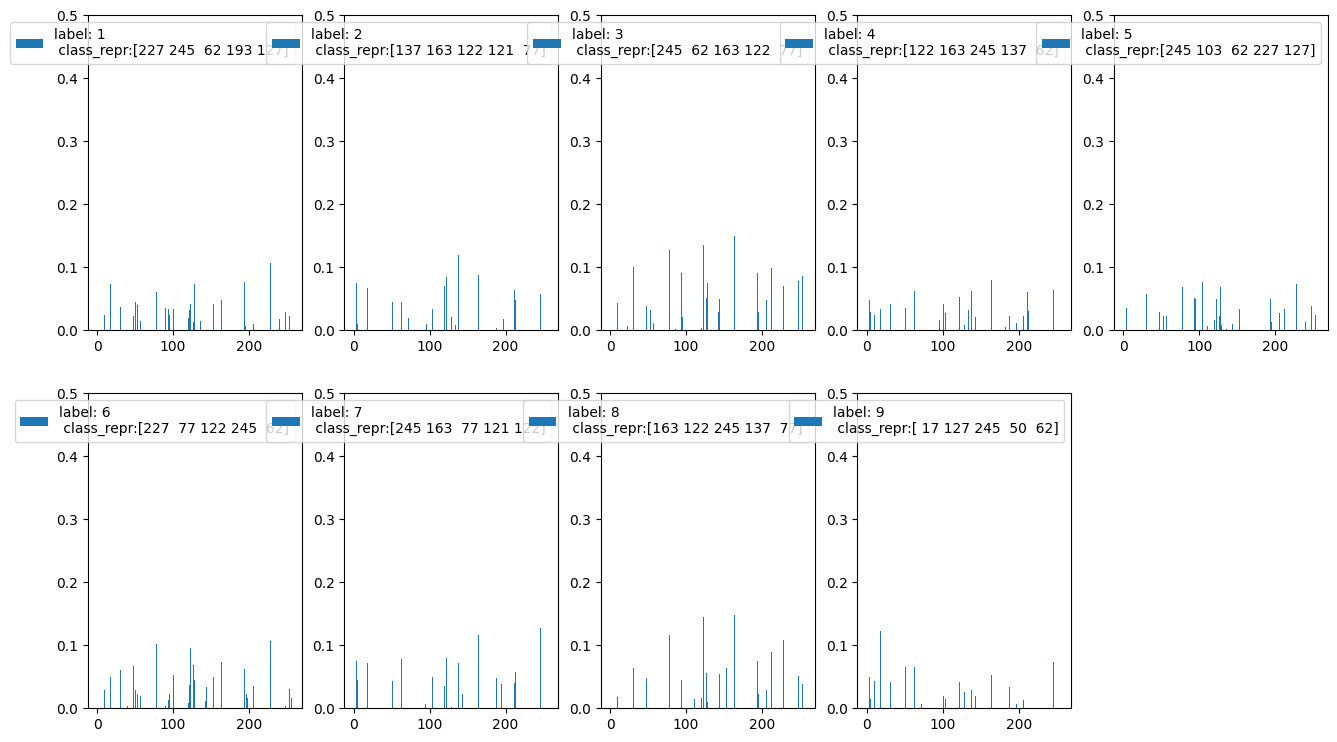

In [109]:
plt.figure(figsize=(16,9))
for n, (k, v) in enumerate(class_output.items()):
    plt.subplot(2,5,n+1)
    class_repr=np.argsort(v.mean(axis=0))[::-1][:5]
    plt.bar(np.arange(1,257), v.mean(axis=0), label=f"label: {k}\n class_repr:{class_repr}")
    plt.ylim(0,0.5)
    plt.legend()

In [28]:
unl_pos = {"unl":0, "pos":0}
for _, i in pu_dataset:
    if i[0].item()==0:
        unl_pos["unl"]+=1
    elif i[0].item()==1:
        unl_pos["pos"]+=1

NameError: name 'pu_dataset' is not defined

In [84]:
unl_pos

{'unl': 4277, 'pos': 223}

In [94]:
cp_pth = ["/workspace/puae/dino/outputs/test/svhn/", "/checkpoints/checkpoint.pth"]
# task = "/workspace/vit_svhn_patch4_input32.pth"
# task = "svhn_class3_resnet18_smallhead_emb128_lr0.0005_weighted-sampler_test" #▽
# task = "svhn_class3_resnet18_smallhead_emb128_lr0.0001_weighted-sampler_test" #×
task = "svhn_class3_resnet18_smallhead_emb128_lr0.0005_SGD_weighted-sampler_test" #×
# task = "svhn_class3_resnet18_smallhead_ep1600_emb128_lr0.0005_weighted-sampler_test" #△
# task = "svhn_class3_resnet18_smallhead_emb128_normlast_weighted-sampler_test" #△
# task = "svhn_class3_resnet18_smallhead_emb64_lr0.0005_weighted-sampler_test" #△
# task = "svhn_class3_resnet18_smallhead_emb128_lr0.0005_dinocrop_weighted-sampler_test" #×

# task = "svhn_class3_resnet50_smallhead_emb128_lr0.0005_weighted-sampler_test" #×
# task = "svhn_class3_resnet50_mediumhead_ep800_customtemp_bs64_emb128_lr0.0005_weighted-sampler_test" #△

cp_pth.insert(1, task)
cp_pth= "".join(cp_pth)


# teacher = VisionTransformer(img_size=[32],
#             patch_size=4,
#             in_chans=3,
#             num_classes=0,
#             embed_dim=192,
#             depth=9,
#             num_heads=12,
#             mlp_ratio=2,
#             qkv_bias=True,
#             drop_rate=0,
#             drop_path_rate=0.1,
#             norm_layer=partial(nn.LayerNorm, eps=1e-6))

teacher = myResNet(BasicBlock, [2,2,2,2], normalize=False)
# teacher = myResNet(Bottleneck, [3,4,6,3], normalize=False)
teacher.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3,bias=False)
teacher.fc = nn.Linear(teacher.fc.in_features, out_features=128, bias=True)
# embed_dim=teacher.embed_dim
# # teacher = vits.__dict__["vit_small"](patch_size=16, normalize=True)
# teacher = ReturnEmbWrapper(
#         teacher,
#         DINOHead(
#             128,
#             256,
#             use_bn=False,
#             norm_last_layer=False,
#             nlayers=2, #3,
#             hidden_dim=128, #512
#             bottleneck_dim=64 #128,
#             ),
#     )

In [43]:
args = vars(torch.load(cp_pth, map_location="cpu")["args"])

In [44]:
args

{'config': 'config.yml',
 'arch': 'resnet18',
 'patch_size': 4,
 'out_dim': 256,
 'norm_last_layer': False,
 'momentum_teacher': 0.996,
 'use_bn_in_head': False,
 'emb_dim': 128,
 'lambda_end': 1,
 'prototype_num': 64,
 'prototype_student_temp': 0.1,
 'nlayers': 2,
 'hidden_dim': 128,
 'bottleneck_dim': 64,
 'resize': 32,
 'warmup_teacher_temp': 0.04,
 'teacher_temp': 0.04,
 'warmup_teacher_temp_epochs': 30,
 'precision': 'bf16',
 'weight_decay': 0.04,
 'weight_decay_end': 0.4,
 'clip_grad': 3.0,
 'batch_size_per_gpu': 256,
 'epochs': 800,
 'freeze_last_layer': 1,
 'lr': 0.0005,
 'warmup_epochs': 30,
 'min_lr': '1e-6',
 'optimizer': 'adamw',
 'drop_path_rate': 0.1,
 'global_crops_scale': [0.7, 1.0],
 'local_crops_number': 8,
 'local_crops_scale': [0.2, 0.5],
 'transform': 'None',
 'output_dir': '/workspace/puae/dino/outputs/test/svhn/svhn_class3_resnet18_smallhead_ptnum64_weighted-sampler_test',
 'saveckp_freq': 10,
 'seed': 0,
 'num_workers': 10,
 'dist_url': 'env://',
 'local_rank': 

In [95]:
state_dict = torch.load(cp_pth, map_location="cpu")["teacher"]
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
backbone_state = {k.replace("backbone.", ""):v for k,v in state_dict.items() if k.startswith("backbone")}
head_state = {k.replace("head.", ""):v for k,v in state_dict.items() if k.startswith("head")}

teacher.load_state_dict(backbone_state, strict=False)
# teacher.backbone.load_state_dict(backbone_state, strict=False)

# teacher.head.load_state_dict(head_state, strict=False)

<All keys matched successfully>

In [96]:
teacher.cuda()
teacher.eval()

myResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


In [97]:
teacher(torch.rand(5,3,32,32).cuda(non_blocking=True)).shape

torch.Size([5, 128])

In [98]:
class_output=defaultdict(list)
transform = transforms.Compose([
    # transforms.Resize(112), 
    transforms.ToTensor(),
    ])
test_dataset = datasets.SVHN(root="/workspace/puae/datasets/SVHN", download=False, split="test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, pin_memory=True)

In [99]:
for images, ids in test_loader:
    with torch.no_grad():
        # output = teacher(images.cuda(non_blocking=True)).cpu().numpy()
        # output = teacher(images.cuda(non_blocking=True))[0][0].cpu().numpy()
        output = teacher(images.cuda(non_blocking=True)).cpu().numpy()
        for out, id in zip(output, ids):
            class_output[id.item()].append(out)

In [100]:
for i in class_output.keys():
        class_output[i] = np.vstack(class_output[i])
class_output = {k: v for k, v in sorted(class_output.items())}

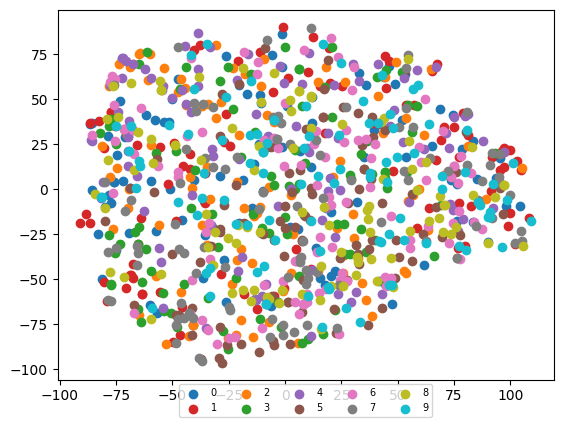

In [101]:
## %matplotlib ipympl
%matplotlib inline

reload(plt)
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

plot_num = 100
colors = ["#1f77b4","#d62728","#ff7f0e","#2ca02c","#9467bd",
"#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf",]
########
emb_dim = class_output[0].shape[-1]
targets_indices = []
pre_len = 0

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

for i in class_output:
    cur_len = len(class_output[i])
    cur_tar = np.array(random.choices(list(range(pre_len, cur_len+pre_len)), k=plot_num))
    targets_indices.append(cur_tar)
    pre_len = cur_len + pre_len
conc_out = np.vstack(list(class_output.values()))
if emb_dim != 2:
    tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
    conc_out = tsne.fit_transform(conc_out)
    # reducer = umap.UMAP(n_components=2)
    # conc_out = reducer.fit_transform(StandardScaler().fit_transform(conc_out))

for n, i in enumerate(targets_indices):
    plt.scatter(*conc_out[i][0], label=n, color=colors[n])
    # ax.scatter(conc_out[i][0][0], conc_out[i][0][1], zs=conc_out[i][0][2], label=n, color=colors[n])
    for k in range(1, min(len(conc_out[i]), plot_num)):
        plt.scatter(*conc_out[i][k], color=colors[n])
        # ax.scatter(conc_out[i][k][0], conc_out[i][k][1], zs=conc_out[i][k][2], color=colors[n])

#plot all
# start_id = 0
# label = 0
# for ind in [len(i) for i in class_output.values()]:
#     print(ind)
#     plt.scatter(*conc_out[start_id:start_id+ind][0], label=label, color=colors[label])
#     plt.scatter(*conc_out[start_id:start_id+ind][1:].T, color=colors[label])
#     label+=1
#     start_id+=ind


plt.legend(loc='upper center', bbox_to_anchor=(.5, -0.0), ncol=5, fontsize=7)
# plt.show()

In [6]:
for k,v in cp_pth["teacher"].items():
    print(k, v.shape)

backbone.cls_token torch.Size([1, 1, 192])
backbone.pos_embed torch.Size([1, 65, 192])
backbone.mask_token torch.Size([1, 1, 192])
backbone.patch_embed.proj.weight torch.Size([192, 3, 4, 4])
backbone.patch_embed.proj.bias torch.Size([192])
backbone.blocks.0.norm1.weight torch.Size([192])
backbone.blocks.0.norm1.bias torch.Size([192])
backbone.blocks.0.attn.qkv.weight torch.Size([576, 192])
backbone.blocks.0.attn.qkv.bias torch.Size([576])
backbone.blocks.0.attn.proj.weight torch.Size([192, 192])
backbone.blocks.0.attn.proj.bias torch.Size([192])
backbone.blocks.0.norm2.weight torch.Size([192])
backbone.blocks.0.norm2.bias torch.Size([192])
backbone.blocks.0.mlp.fc1.weight torch.Size([384, 192])
backbone.blocks.0.mlp.fc1.bias torch.Size([384])
backbone.blocks.0.mlp.fc2.weight torch.Size([192, 384])
backbone.blocks.0.mlp.fc2.bias torch.Size([192])
backbone.blocks.1.norm1.weight torch.Size([192])
backbone.blocks.1.norm1.bias torch.Size([192])
backbone.blocks.1.attn.qkv.weight torch.Size([

In [123]:
pu_dataset, pu_val_dataset = load(
        name="SVHN",
        batch_size=False,
        normal_class=[3],
        unseen_anomaly=[0],
        labeled_anomaly_class=False, 
        n_train = 4500,
        n_valid = 500,
        # n_test = 2000,
        n_unlabeled_normal = 4500, #n_unlabeled_normal
        n_unlabeled_anomaly = 250, #n_unlabeled_anomaly
        n_labeled_anomaly = 250, #n_labeled_anomaly
        return_extra_test_loader= False,
        return_subset=True,
        return_unl_pos_subset=False, 
        # transform = val_transform,
        seed=0, 
        return_id = False
        )

Using downloaded and verified file: /workspace/puae/datasets/SVHN/train_32x32.mat
Using downloaded and verified file: /workspace/puae/datasets/SVHN/test_32x32.mat
Using downloaded and verified file: /workspace/puae/datasets/SVHN/train_32x32.mat
tensor([3, 3, 3,  ..., 3, 3, 3])


In [124]:
pu_dataset.dataset.__getitem__(0)

(tensor([0.3992, 0.3895, 0.3895,  ..., 0.2937, 0.2946, 0.2971]), 1)

### 代表ベクトルの確認

In [3]:
def get_datasets(name="MNIST", normal_class=1, seed=0):
    if name == "MNIST": stats = ((0.1307,), (0.3081,))
    elif name == "CIFAR10": stats = ((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
    elif name == "FashionMNIST": stats = ((0.2860,), (0.3530,))
    elif name == "SVHN": stats = ((0.4377, 0.4438, 0.4728), (0.198, 0.201, 0.197))
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(*stats),
    ])
    # if name == "MNIST":
    #     test_dataset = datasets.MNIST(root="/workspace/puae/datasets", download=False, train=False, transform=val_transform)
    # elif name == "CIFAR10":
    #     test_dataset = datasets.CIFAR10(root="/workspace/puae/datasets/CIFAR10", download=False, train=False, transform=val_transform)
    # elif name == "FashionMNIST":
    #     test_dataset = datasets.FashionMNIST(root="/workspace/puae/datasets", download=False, train=False, transform=val_transform)
    # elif name == "SVHN":
    #     test_dataset = datasets.SVHN(root="/workspace/puae/datasets/SVHN", download=False, split="test", transform=val_transform)
    test_dataset = load(name, normal_class=[normal_class], unseen_anomaly=[0],return_test_subset=True, seed=seed, return_id = True)
    pu_dataset, pu_val_dataset = load(
        name=name,
        batch_size=False,
        normal_class=[normal_class],
        unseen_anomaly=[0],
        labeled_anomaly_class=False, 
        n_train = 4500,
        n_valid = 500,
        # n_test = 2000,
        n_unlabeled_normal = 4500, #n_unlabeled_normal
        n_unlabeled_anomaly = 250, #n_unlabeled_anomaly
        n_labeled_anomaly = 250, #n_labeled_anomaly
        return_extra_test_loader= False,
        return_subset=True,
        return_unl_pos_subset=False, 
        transform = val_transform,
        seed=seed, 
        return_id = False
        )
    pu_loader = DataLoader(dataset=pu_dataset, batch_size=100, shuffle=False, num_workers=8,
           drop_last=False, pin_memory=True)
    pu_val_loader = DataLoader(dataset=pu_val_dataset, batch_size=100, shuffle=False, num_workers=8,
           drop_last=False, pin_memory=True)
    return pu_dataset, pu_val_dataset, pu_loader, pu_val_loader, test_dataset

def get_result(model, cp_path, dataset="MNIST", repr_vec_weight=None, normal_class=1, seed=0, varbose=True):
    # print("loading check point")
    # load_pretrained_backbone_head(model, cp_path, checkpoint_key="Teacher")
    print("preparing dataset")
    pu_dataset, pu_val_dataset, pu_loader, pu_val_loader, test_dataset = get_datasets(dataset, normal_class, seed=seed)
    print("obtaining repr vecs")
    pu_unlabel_vec_dict, pu_positive_vec_dict, pu_normal_repr_dict, pu_normal_repr_dict_id = get_repr_vec_ids(model, pu_loader, pu_val_loader, repr_vec_weight)
    if varbose:
        print(f"unlabel_repr_vec_ids = {list(pu_unlabel_vec_dict.keys())[:5]}, total dot = {list(map(lambda x: round(x, 4), pu_unlabel_vec_dict.values()))[:5]}")
        print(f"positive_repr_vec_ids = {list(pu_positive_vec_dict.keys())[:5]}, total dot = {list(map(lambda x: round(x, 4), pu_positive_vec_dict.values()))[:5]}")
        print(f"noraml_repr_vec_ids = {list(pu_normal_repr_dict.keys())[:5]}, total dot = {list(map(lambda x: round(x, 4), pu_normal_repr_dict.values()))[:5]}")
        print(f"noraml_repr_vec_ids = {pu_normal_repr_dict_id}")

    if varbose: print("calculating score")
    y_true, y_score, y_each_class, dot_each_class, dot_pos = calc_y_score(model, test_dataset, pu_normal_repr_dict_id, pu_unlabel_vec_dict, pu_positive_vec_dict, pu_normal_repr_dict, repr_vec_weight, normal_class, varbose)
    if varbose: 
        print("y_true, y_score example ")
        for n, (t, s) in enumerate(zip(y_true, y_score)):
            print(t, s)
            if n == 9: break

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auroc = roc_auc_score(y_true, y_score)
    if varbose:
        print("showing ROC curve")
        plt.figure(figsize=(16,9))
        plt.plot(fpr, tpr, marker='o')
        plt.xlabel('FPR: False positive rate')
        plt.ylabel('TPR: True positive rate')
        plt.grid()
        plt.title(f"AUROC = {auroc:.4f}")
    print(f"AUROC: {auroc}")
    
    if varbose:
        conf_score = np.copy(y_score)
        conf_score = np.where(conf_score>0.5, 1, conf_score).astype(int)
        print("confusion_matrix, thresholds=0.5")
        print(confusion_matrix(y_true, conf_score.tolist()))
        plot_class_scores(y_each_class, normal_class)
        plot_class_repr_dot(dot_each_class, dot_pos)
    return auroc

def get_repr_vec(cp_path):
    repr_vec_weight = nn.utils.weight_norm(nn.Linear(64, 100, bias=False)).cuda()
    repr_vec_weight.weight_g.data.fill_(1)
    repr_vec_weight.weight_g.requires_grad = False
    state_repr_vec = torch.load(cp_path, map_location="cpu")["t_repr_vec"]
    repr_vec_weight.load_state_dict(state_repr_vec)
    repr_vec_weight.eval()
    repr_vec_weight(torch.eye(64).cuda(non_blocking=True))
    return repr_vec_weight

def construct_model(dataset_name="MNIST"):
    embed_dim=64
    arcface_family_conf = {"name":False}
    if "MNIST" in dataset_name: ch=1
    else: ch=3

    teacher = myResNet(BasicBlock, [2,2,2,2], normalize=True)
    # teacher = myResNet(Bottleneck, [3,4,6,3], normalize=True)
    teacher.conv1 = nn.Conv2d(ch, 64, kernel_size=7, stride=1, padding=3,bias=False)
    teacher.fc = nn.Linear(teacher.fc.in_features, out_features=embed_dim, bias=True)
    # teacher = CustomWrapper(
    #         teacher,
    #         DINOHead(embed_dim, 512, False, arcface_family_conf=arcface_family_conf,
    #             nlayers=3,
    #             hidden_dim=512,
    #             bottleneck_dim=128,
    #             ),
    #     )
    teacher = ReturnEmbWrapper(
            teacher,
            DINOHead(
                64,
                256,
                use_bn=False,
                norm_last_layer=False,
                nlayers=2, #3,
                hidden_dim=128, #512
                bottleneck_dim=64 #128,
                ),
        )
    
    return teacher


def load_pretrained_backbone_head(model, cp_path, checkpoint_key="Teacher"):
    model.cuda()
    state_dict = torch.load(cp_path, map_location="cpu")["teacher"]
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    backbone_state = {k.replace("backbone.", ""):v for k,v in state_dict.items() if k.startswith("backbone")}
    head_state = {k.replace("head.", ""):v for k,v in state_dict.items() if k.startswith("head")}
    model.backbone.load_state_dict(backbone_state, strict=False)
    model.head.load_state_dict(head_state, strict=False)
    model.eval()

def plot_embedding(val_loader, model, repr_vec_weight):
    model.eval()
    emb_list=defaultdict(list)

    for images, ids in val_loader:
        with torch.no_grad():
            output = model.backbone(images.cuda(non_blocking=True))
            for n, out in enumerate(output):
                emb_list[ids[n].item()].append(out.cpu())
            
    emb_list = dict(sorted(emb_list.items(), key=lambda x: x[0]))
    emb_numpy = torch.vstack(sum(list(emb_list.values()), [])).numpy()
    repr_vec_numpy = repr_vec_weight.weight.data.cpu().detach().numpy()[:]

    emb_repr_numpy = np.vstack([emb_numpy, repr_vec_numpy])
    # tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
    _umap = umap.UMAP(n_neighbors=15, n_components=2, metric="cosine", min_dist=0.7, spread=0.7)
    # emb_tsne = tsne.fit_transform(emb_repr_numpy)
    emb_tsne = _umap.fit_transform(emb_repr_numpy)
    return emb_tsne, emb_list

def select_unique_random_indices(arr, num=1):
    # ユニークな要素を取得
    unique_elements = set(arr)
    unique_indices = defaultdict(list)
    for id, cls in enumerate(arr):
        unique_indices[cls].append(id)
    selected_indices = {k:random.sample(list(v), min(num, len(v))) for k,v in unique_indices.items()}

    # # ユニークな要素のインデックスを保持する辞書
    # unique_indices = defaultdict(list)
    # for index, value in enumerate(arr):
    #     unique_indices[value].append(index)
    
    # # print(unique_indices)
    # unique_indices = dict(sorted(unique_indices.items(), key=lambda x:x[0]))
    # # print(unique_indices)
    # # ユニークな要素からランダムにインデックスを選択
    # # selected_indices = [unique_indices[element] for element in random.sample(list(unique_elements), len(unique_elements))]
    # if num==1:
    #     selected_indices = {k:random.choice(list(v)) for k,v in unique_indices.items()}
    # else:
    #     selected_indices = {k:random.sample(list(v), num) for k,v in unique_indices.items()}
    return selected_indices

def plot_class_scores(y_each_class, normal_class=1):
    plt.figure(figsize=(12,9))
    for n, (k, v) in enumerate(y_each_class.items()):
        plt.subplot(2,5, n+1)
        plt.bar(np.arange(len(v))[:], v[:], label=f"class id{k}\nmean:{np.mean(v):.4f}")
        plt.ylim(-0.1,0.5)
        plt.legend(handlelength=0, frameon=False)
    plt.suptitle("normal repr vec cos similarity")
    plt.tight_layout()

    plt.figure(figsize=(12,9))
    anomaly_scores = []
    for k,v in y_each_class.items():
        if k!=normal_class:
            anomaly_scores.extend(v)
        else:
            normal_scores = v

    max_ = max(max(anomaly_scores), max(normal_scores))
    min_ = min(min(anomaly_scores), min(normal_scores))
    anomaly_scores = (np.array(anomaly_scores)-min_) / (max_-min_)
    normal_scores = (np.array(normal_scores)-min_) / (max_-min_)

    # bn = np.linspace(-1, 1, 10)
    bn = np.array(range(0,11))/10
    # bn = np.linspace(min_, max_, 10)
    plt.hist(anomaly_scores, label="normlity score from anomarly samples", bins=bn, color="red", ec="black", alpha=0.7)
    plt.hist(normal_scores, label="normlity score from normal samples", bins=bn, color="blue", ec="black", alpha=0.7)
    plt.legend()
    plt.title("normality score hist ano vs norm")
    print(f"anomaly scores: {[round(i, 4)for i in anomaly_scores]}")
    print(f"normal scores: {[round(i, 4)for i in normal_scores]}")

def plot_class_repr_dot(dot_each_class, dot_pos):
    plt.figure(figsize=(12,9))
    for n, (k, v) in enumerate(dot_each_class.items()):
        max_id = np.argsort(v)[:5]
        plt.subplot(3,5, n+1)
        plt.bar(np.arange(len(v))[:], v[:], label=f"class id{k}\nmax_ids:{max_id}")
        plt.ylim(-0.1,0.5)
        plt.legend(handlelength=0, frameon=False)
    plt.subplot(3,5, n+2)
    max_id = np.argsort(dot_pos)[:5]
    plt.bar(np.arange(len(dot_pos))[:], dot_pos[:], label=f"positive\nmax_ids:{max_id}")
    plt.ylim(-0.1,0.5)
    plt.legend(handlelength=0, frameon=False)

def calc_y_score(model, val_dataset, pu_normal_repr_dict_id, pu_unlabel_vec_dict, pu_positive_vec_dict, pu_normal_repr_dict, repr_vec_weight=None, normal_class=1, varbose=True):
    # normal_repr_vec = head_state["last_layer.weight_v"][pu_normal_repr_dict_id,:]
    if not repr_vec_weight:
        normal_repr_vec = model.head.last_layer.weight_v.detach().cpu().clone()
        normal_repr_vec /= torch.norm(normal_repr_vec, p=2)
    else:
        normal_repr_vec = repr_vec_weight.weight.data.detach().cpu().clone()

    # if not repr_vec_weight:
    #     normal_repr_vec = model.head.last_layer.weight_v.detach().cpu().clone()[pu_normal_repr_dict_id,:]
    #     normal_repr_vec /= torch.norm(normal_repr_vec, p=2)
    # else:
    #     normal_repr_vec = repr_vec_weight.weight.data.detach().cpu().clone()[pu_normal_repr_dict_id,:]
    #     # normal_repr_vec = repr_vec_weight.weight.data.detach().cpu().clone()
    # print(f"代表ベクトルのshape: {normal_repr_vec.shape}, norm: {normal_repr_vec.norm(dim=1, p=2)}")

    ################
    top5_normal_repr_ids = list(pu_normal_repr_dict.keys())[:10]
    # top5_normal_repr_ids = [2,93,57,51,6]
    # top5_normal_repr_ids = list(pu_unlabel_vec_dict.keys())[:5]
    top5_positive_repr_ids = list(pu_positive_vec_dict.keys())[:10]
    # top5_normal_repr_ids = [i for i in top5_normal_repr_ids if i not in top5_positive_repr_ids]

    # top5_normal_repr_vecs= head_state["last_layer.weight_v"][top5_normal_repr_ids,:]
    if not repr_vec_weight:
        top5_normal_repr_vecs= normal_repr_vec[top5_normal_repr_ids,:]
    else:
        top5_normal_repr_vecs = normal_repr_vec[top5_normal_repr_ids,:]
        top5_positive_repr_vecs = normal_repr_vec[top5_positive_repr_ids,:]
    if varbose:
        print(f"top5正常代表ベクトルのindex: {top5_normal_repr_ids}")
        print(f"top5異常代表ベクトルのindex: {top5_positive_repr_ids}")
    # print(f"top5正常代表ベクトルのshape: {top5_normal_repr_vecs.shape}, norm: {top5_normal_repr_vecs.norm(dim=1, p=2)}")
    top5_normal_repr_wights = list(pu_normal_repr_dict.values())[:10]
    top5_positive_repr_wights = list(pu_positive_vec_dict.values())[:10]
    if varbose:
        print(f"top5_normal_repr_weights: {top5_normal_repr_wights}")
    top5_normal_repr_wights = nn.functional.softmax(torch.tensor(top5_normal_repr_wights)/0.5, dim=0, dtype=torch.float32)
    top5_positive_repr_wights = nn.functional.softmax(torch.tensor(top5_positive_repr_wights)/0.5, dim=0, dtype=torch.float32)
    if varbose:
        print(f"top5_normal_repr_softmax_weights: {top5_normal_repr_wights}")
        print(f"top5_positive_repr_softmax_weights: {top5_positive_repr_wights}")
    ################

    random.seed(42)
    #正常データのindex 
    # try: indices = val_dataset.targets
    # except: indices = val_dataset.labels
    try: targets = val_dataset.dataset.targets
    except: targets = val_dataset.dataset.labels
    if not torch.is_tensor(targets): targets = torch.tensor(targets)
    indices = targets[val_dataset.indices]
    normal_indices = (indices==normal_class).nonzero().flatten()
    anomaly_indices = (indices!=normal_class).nonzero().flatten()
    print(len(normal_indices), len(anomaly_indices))
    
    # if not torch.is_tensor(indices):
    #     indices = torch.tensor(indices)
    # normal_indices = (indices==1).nonzero().flatten()
    # normal_indices = random.sample(normal_indices.tolist(), 1000)
    # #異常データのindex
    # anomaly_indices = (indices!=1).nonzero().flatten()
    # anomaly_indices = random.sample(anomaly_indices.tolist(), 1000)

    #結果の配列
    y_true = []
    y_score = []
    y_each_class = defaultdict(list)
    dot_each_class = defaultdict(lambda: np.zeros(normal_repr_vec.shape[0]))
    class_sample_num = {k:0 for k in range(10)}
    dot_pos = np.zeros(normal_repr_vec.shape[0])

    for sample, id in val_dataset:
        # if i in normal_indices:
        #     y_true.append(0)
        # elif i in anomaly_indices:
        #     y_true.append(1)
        # else: continue
        # sample, id = val_dataset.__getitem__(i)
        # print(id)
        # if id==0: 
        #     print(id)
        #     continue
        if id==normal_class: y_true.append(0)
        elif id!=normal_class: y_true.append(1)
        if varbose:
            print(id)
            print(Counter(y_true))
        sample = sample.unsqueeze(0)
        if not repr_vec_weight:
            with torch.no_grad():
                head_emb = model(sample.cuda(non_blocking=True), return_emb=True)[0].cpu()
                head_emb = nn.functional.normalize(head_emb.unsqueeze(0), p=2)[0]
                score = (normal_repr_vec @ head_emb).item()
                y_score.append(score)
                y_each_class[id].append(score)
                
        else:
            with torch.no_grad():
                backbone_emb = model.backbone(sample.cuda(non_blocking=True))[0].cpu()
                # backbone_emb = nn.functional.normalize(backbone_emb.unsqueeze(0), p=2)[0]
                # y_score.append(((normal_repr_vec @ backbone_emb).item()))

                # score = (top5_normal_repr_vecs @ backbone_emb).mean().item() #meanではなくmaxも試す
                # score = (top5_normal_repr_vecs @ backbone_emb).max().item() #meanではなくmaxも試す
                # score = ((top5_normal_repr_vecs @ backbone_emb) @ top5_normal_repr_wights).item()
                # score = ((top5_normal_repr_vecs @ backbone_emb) * top5_normal_repr_wights).max().item()
                score = (top5_normal_repr_vecs @ backbone_emb).mean().item() - \
                    (top5_positive_repr_vecs @ backbone_emb).mean().item()
                # score = ((top5_normal_repr_vecs @ backbone_emb) @ top5_normal_repr_wights).item() - \
                #     ((top5_positive_repr_vecs @ backbone_emb) @ top5_positive_repr_wights).item()*0.5
                # score = ((top5_normal_repr_vecs @ backbone_emb) - (top5_positive_repr_vecs @ backbone_emb)*0.5).max().item()
                # score = (((top5_normal_repr_vecs @ backbone_emb) * top5_normal_repr_wights) - \
                #     ((top5_positive_repr_vecs @ backbone_emb) * top5_positive_repr_wights)*0.5).max().item()
                y_score.append(score)
                if varbose:
                    print((1-score)/2)
                # print((2-score)/4)
                # y_score.append( ((top5_normal_repr_vecs @ backbone_emb) @ top5_normal_repr_wights).item())

                # backbone_emb = model.backbone(sample.cuda(non_blocking=True))[0]
                # sf_out = nn.functional.softmax(repr_vec_weight(backbone_emb)).cpu()
                # y_score.append(sf_out[pu_normal_repr_dict_id])
                y_each_class[id].append(score)
                dot_each_class[id] += (normal_repr_vec @ backbone_emb).numpy()
                class_sample_num[id] += 1
                if id != normal_class:
                    dot_pos += (normal_repr_vec @ backbone_emb).numpy()


        ##################
        # y_score.append((top5_normal_repr_vecs @ head_emb).mean().item())
        # y_score.append( ((top5_normal_repr_vecs @ head_emb) @ top5_normal_repr_wights).item())
        ##################
    # print(normal_repr_vec.shape, backbone_emb.shape, normal_repr_vec.norm(dim=1), backbone_emb.norm(), (normal_repr_vec @ backbone_emb).numpy())
    y_score = np.array(y_score)
    y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())
    y_score = 1 - y_score
    # y_score = (1-y_score)/2
    # y_score = (2-y_score)/4
    y_each_class = dict(sorted(y_each_class.items(), key=lambda x: x[0]))
    dot_each_class = dict(sorted(dot_each_class.items(), key=lambda x: x[0]))
    dot_each_class = {k:v/class_sample_num[k] for k,v in dot_each_class.items()}
    if varbose:
        plt.figure(figsize=(16,9))
        plt.bar(list(range(len(y_score))), y_score)
        # plt.bar(list(range(len(y_score))), y_true)
        print(Counter(y_true))
    return y_true, y_score, y_each_class, dot_each_class, dot_pos/1000

def get_repr_vec_ids(model, pu_loader, pu_valloader, repr_vec_weight=None):
    # import pdb; pdb.set_trace()

    num_unlabel = 0
    num_positive = 0
    for _,i in pu_loader:
        i = i.tolist()
        c = Counter(i)
        num_unlabel+=c[0]
        num_positive+=c[1]
    for _,i in pu_valloader:
        i = i.tolist()
        c = Counter(i)
        num_unlabel+=c[0]
        num_positive+=c[1]
    print("num unl pos",num_unlabel, num_positive)

    num_unlabel = 0
    num_positive = 0
    pu_num = 0
    val_num=0
    for _,i in pu_loader:
        for k in i:
            if k==0: num_unlabel+=1
            elif k==1: num_positive+=1
            else: raise NotImplementedError()
            pu_num+=1
    for _,i in pu_valloader:
        for k in i:
            if k==0: num_unlabel+=1
            elif k==1: num_positive+=1
            else: raise NotImplementedError()
            val_num+=1
    print("num unl pos",num_unlabel, num_positive, pu_num, val_num)

    pu_unlabel_vec_dict = defaultdict(float)
    pu_positive_vec_dict = defaultdict(float)

    #####
    for images, unl_pos in pu_loader:
        images = images.cuda(non_blocking=True)
        if not repr_vec_weight:
            with torch.no_grad():
                output = model(images)[0][0]
        else:
            with torch.no_grad():
                output = repr_vec_weight(model.backbone(images))
        output =  output.cpu().detach()
        sorted_out, sorted_arg = torch.sort(output, dim=1, descending=True)
        sorted_out, sorted_arg = sorted_out.numpy()[:, :5], sorted_arg.numpy()[:, :5]
        for n, (out, arg) in enumerate(zip(sorted_out, sorted_arg)):
            if unl_pos[n] == 0:
                for o, a in zip(out, arg):
                    pu_unlabel_vec_dict[a] += o/num_unlabel
            elif unl_pos[n] == 1:
                for o, a in zip(out, arg):
                    pu_positive_vec_dict[a] += o/num_positive
            else: raise NotImplementedError
    
    for images, unl_pos in pu_valloader:
        images = images.cuda(non_blocking=True)
        if not repr_vec_weight:
            with torch.no_grad():
                output = model(images)[0][0]
        else:
            with torch.no_grad():
                output = repr_vec_weight(model.backbone(images))
        output =  output.cpu().detach()
        sorted_out, sorted_arg = torch.sort(output, dim=1, descending=True)
        sorted_out, sorted_arg = sorted_out.numpy()[:, :5], sorted_arg.numpy()[:, :5]
        for n, (out, arg) in enumerate(zip(sorted_out, sorted_arg)):
            if unl_pos[n] == 0:
                for o, a in zip(out, arg):
                    pu_unlabel_vec_dict[a] += o/num_unlabel
            elif unl_pos[n] == 1:
                for o, a in zip(out, arg):
                    pu_positive_vec_dict[a] += o/num_positive
            else: raise NotImplementedError

    pu_unlabel_vec_dict = dict(sorted(pu_unlabel_vec_dict.items(), key=lambda x: x[1], reverse=True))
    pu_positive_vec_dict = dict(sorted(pu_positive_vec_dict.items(), key=lambda x: x[1], reverse=True))
    pu_normal_repr_dict = pu_unlabel_vec_dict.copy()

    for k in pu_positive_vec_dict:
        if k in pu_normal_repr_dict.keys():
            pu_normal_repr_dict[k] -= pu_positive_vec_dict[k]

    pu_normal_repr_dict = dict(sorted(pu_normal_repr_dict.items(), key=lambda x: x[1], reverse=True))
    pu_normal_repr_dict_id = list(pu_normal_repr_dict.keys())[0]
    return  pu_unlabel_vec_dict, pu_positive_vec_dict, pu_normal_repr_dict, pu_normal_repr_dict_id

In [120]:
pu_dataset, pu_val_dataset, *_ = load(
        name="MNIST", batch_size=False,
        normal_class=[1], unseen_anomaly=[0], labeled_anomaly_class=False, 
        n_train = 4500, n_valid = 500, # n_test = 2000,
        n_unlabeled_normal = 4500, #n_unlabeled_normal
        n_unlabeled_anomaly = 250, #n_unlabeled_anomaly
        n_labeled_anomaly = 250, #n_labeled_anomaly
        return_extra_test_loader= False, return_subset=False,
        return_pu_pos_tra_valtrans_val_subset = True,
        seed=0, return_id = True
        )

tensor([1, 1, 1,  ..., 1, 1, 1])
5000
4500
4500 223 4277 223 500


In [131]:
pu_dataset.__getitem__(4276)[1]

tensor([0, 1])

tensor([3, 3, 3,  ..., 3, 3, 3])
tensor([3, 3, 3,  ..., 3, 3, 3])
tensor([3, 3, 3,  ..., 3, 3, 3])
5000
4500
4500 223 4277 223 500


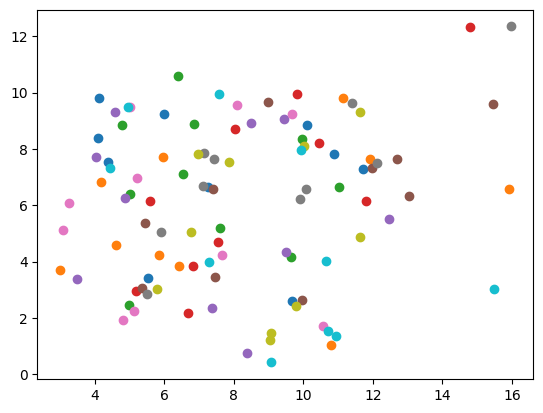

In [115]:
normal_class = 3

pu_dataset, pu_val_dataset, pu_loader, \
    pu_val_loader, test_dataset = get_datasets("MNIST", normal_class=normal_class, seed=10)

stats = ((0.1307,), (0.3081,))#"MNIST": 
# stats = ((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))#"CIFAR10": 
# stats = ((0.2860,), (0.3530,))#"FashionMNIST": 
# stats = ((0.4377, 0.4438, 0.4728), (0.198, 0.201, 0.197))#"SVHN": 
val_transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(*stats),
])
pu_dataset, pu_val_dataset, *_ = load(
        name="MNIST", batch_size=False,
        normal_class=[normal_class], unseen_anomaly=[0], labeled_anomaly_class=False, 
        n_train = 4500, n_valid = 500, # n_test = 2000,
        n_unlabeled_normal = 4500, #n_unlabeled_normal
        n_unlabeled_anomaly = 250, #n_unlabeled_anomaly
        n_labeled_anomaly = 250, #n_labeled_anomaly
        return_extra_test_loader= False, return_subset=False,
        return_pu_pos_tra_valtrans_val_subset = True,
        return_unl_pos_subset=False, transform=val_transform,
        seed=0, return_id = False
        )

test_loader = DataLoader(pu_dataset, batch_size=100, shuffle=False, num_workers=8,
           drop_last=False, pin_memory=True)

# task_name = "test/emb_loss_4"
# # task_name = "test/cifar10_emb_loss"
# task_name= "test/mnist/trials/arcface-m0.5-step50/trial1/mnist_class9_resnet18_ptnum100_ep200_bs128_lambda1.0-warmup100_arcface-m0.5-step50-num10_useweight_embdim64_smallhead_emb64_lr0.0005-weighted-sampler_test"
task_name = f"test/mnist/trials/tea-stu-arcface-m0.5-step50/trial2/mnist_class{normal_class}_resnet18_ptnum100_ep200_bs128_lambda1.0-warmup100_tea-stu-arcface-m0.5-step50-num10_useweight_smallhead_emb64_lr0.0005-weighted-sampler_test"


cp_path = "/workspace/puae/dino/outputs/"+ task_name +"/checkpoints/checkpoint.pth"
dataset_name = "MNIST" #"CIFAR10" #

teacher = construct_model(dataset_name)
load_pretrained_backbone_head(teacher, cp_path, checkpoint_key="Teacher")
repr_vec_weight = get_repr_vec(cp_path)

tsne_result, emb_list = plot_embedding(test_loader, teacher, repr_vec_weight)
tsne_emb = tsne_result[:-100]
tsne_weight = tsne_result[-100:]

colors = ["#9ae00d","#d62728","#ff7f0e","#2ca02c","#9467bd",
        "#8c564b","#e377c2","#7f7f7f","#bcbd22","#f2f540",]
normal_color = "#6666d1"

colors = ["#1f77b4","#ff7f0e","#d62728","#9467bd",
        "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"]
normal_color = "#2ca02c"
colors.insert(normal_class, normal_color)

test_targets = test_dataset.dataset.targets[test_dataset.indices].tolist()
# sorted_targets = sorted(test_targets) if torch.is_tensor(test_dataset.targets) else test_dataset.targets
plot_index = select_unique_random_indices(test_targets, 10)
for i in range(10):
    # plt.scatter(*tsne_emb[plot_index[i]].T, color=colors[i] if not i==9 else normal_color, label=None if not i==9 else "normal")
    plt.scatter(*tsne_emb[plot_index[i]].T, color=colors[i])

# for i in [35, 27, 4, 69, 33]:
#     plt.scatter(*tsne_weight[i].T, color="red", edgecolors="gray", marker="*", s=600, zorder=-1)

# for i in [92, 10, 34, 65, 81]:
#     plt.scatter(*tsne_weight[i].T, color="black", marker="*", s=600, zorder=-1)
# plt.legend(ncol=2)
# plt.title("Low-dimensional embeddings from UMAP")

In [4]:
task_name = "test/cifar10/cifar10_class9_resnet50_ptnum100_ep800_bs128_lambda1.0_bufferd-posmargin0.1-50-400_woweight_embdim64_smallhead_emb64_lr0.001-weighted-sampler_test"
task_name = "test/fashionmnist/fmnist_class3_resnet18_ptnum100_ep200_bs128_lambda1.0_bufferd-posmargin0.1-50-100_woweight_embdim64_smallhead_emb64_lr0.0005-weighted-sampler_test"
task_name = "test/fashionmnist/fmnist_class3_resnet18_ptnum100_ep200_bs128_lambda1.0_bufferd-posunlmargin0.1-50-100_woweight_embdim64_smallhead_emb64_lr0.0005-weighted-sampler_test"
task_name = "test/fashionmnist/fmnist_class3_resnet18_ptnum100_ep200_bs128_lambda1.0_woweight_embdim64_smallhead_emb64_lr0.0005-weighted-sampler_test"
task_name = "test/fashionmnist/fmnist_class3_resnet18_ptnum100_ep200_bs128_lambda1.0_useweight_embdim64_smallhead_emb64_lr0.0005-weighted-sampler_test"
task_name = "test/mnist/trials/arcface-m0.5-step50/trial1/mnist_class9_resnet18_ptnum100_ep200_bs128_lambda1.0-warmup100_arcface-m0.5-step50-num10_useweight_embdim64_smallhead_emb64_lr0.0005-weighted-sampler_test"
task_name = "test/mnist/trials/tea-stu-arcface-m0.5-step50/trial5/mnist_class9_resnet18_ptnum100_ep200_bs128_lambda1.0-warmup100_tea-stu-arcface-m0.5-step50-num10_useweight_smallhead_emb64_lr0.0005-weighted-sampler_test"
task_name = "test/fashionmnist/trials/tea-stu-arcface-m0.5-step50/trial1/fmnist_class1_resnet18_ptnum100_ep200_bs128_lambda1.0-warmup100_tea-stu-arcface-m0.5-step50-num10_useweight_smallhead_emb64_lr0.0005-weighted-sampler_test"

cp_path = "/workspace/puae/dino/outputs/"+ task_name +"/checkpoints/checkpoint.pth"
dataset_name = "FashionMNIST" #"CIFAR10" #SVHN #FashionMNIST #MNIST

teacher = construct_model(dataset_name)
load_pretrained_backbone_head(teacher, cp_path, checkpoint_key="Teacher")
repr_vec_weight = get_repr_vec(cp_path)
auroc = get_result(teacher, cp_path, dataset_name, repr_vec_weight, normal_class=1, seed=0, varbose=True)

# score = 0.0
# seeds = list(range(0,31)) #list(range(31,61)) #
# score_dict={}
# for s in seeds:
#     scores = []
#     for i in range(1,10):
#         task_name= f"test/mnist/trials/tea-stu-arcface-m0.5-step50/trial5/mnist_class{i}_resnet18_ptnum100_ep200_bs128_lambda1.0-warmup100_tea-stu-arcface-m0.5-step50-num10_useweight_smallhead_emb64_lr0.0005-weighted-sampler_test"
#         cp_path = "/workspace/puae/dino/outputs/"+ task_name +"/checkpoints/checkpoint.pth"

#         teacher = construct_model(dataset_name)
#         load_pretrained_backbone_head(teacher, cp_path, checkpoint_key="Teacher")
#         repr_vec_weight = get_repr_vec(cp_path)
#         auroc = get_result(teacher, cp_path, dataset_name, repr_vec_weight, normal_class=i, seed=s, varbose=False)

#         scores.append(auroc)
#     new_score = np.mean(scores)
#     print(f"seed:{s} auroc:{new_score:.4f}")
#     score_dict[str(s)] = new_score
#     if new_score > score:
#         score=new_score
#     if score > 0.9966: break

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.58 GiB of which 5.25 MiB is free. Process 284218 has 23.32 GiB memory in use. Process 410229 has 246.00 MiB memory in use. Of the allocated memory 33.65 MiB is allocated by PyTorch, and 10.35 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [9]:
for i in scores:
    print(str(i)[:6], end=" ")

0.9999 0.9990 0.9996 0.9998 0.9992 0.9988 0.9993 0.9929 0.9818 

In [10]:
dict(sorted(score_dict.items(), key=lambda x: x[1], reverse=True))

{'13': 0.9967417107582178,
 '10': 0.9964233643638681,
 '7': 0.9961592001104935,
 '2': 0.9960799763087105,
 '4': 0.9960654927851329,
 '6': 0.9960573746970801,
 '9': 0.9960337656644206,
 '0': 0.9959725256619176,
 '12': 0.9959297802187902,
 '8': 0.9958826090127162,
 '11': 0.9957709645837739,
 '3': 0.995765329529934,
 '5': 0.9957624191672367,
 '1': 0.9956638303144426}

In [130]:
F.softmax(torch.tensor([0.1,0.1,0.2,0.2,0.3,0.3,0.2,0.2,0.1,0.2])/0.5)

/tmp/ipykernel_2008437/2439524709.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(torch.tensor([0.1,0.1,0.2,0.2,0.3,0.3,0.2,0.2,0.1,0.2])/0.5)


tensor([0.0827, 0.0827, 0.1010, 0.1010, 0.1234, 0.1234, 0.1010, 0.1010, 0.0827,
        0.1010])

In [126]:
z = torch.zeros(5,5)
magin_ids = torch.tensor([0,1,3])
pos=torch.tensor([0,1])
unl=torch.tensor([2,3,4])
pos_magin_ids = torch.cartesian_prod(pos, magin_ids)
unl_magin_ids = torch.cartesian_prod(unl, magin_ids)
z[pos_magin_ids[:,0], pos_magin_ids[:,1]]=torch.tensor([1,2,3], dtype=torch.float32).repeat(1,len(pos))
z[unl_magin_ids[:,0], unl_magin_ids[:,1]]=-1

z

tensor([[ 1.,  2.,  0.,  3.,  0.],
        [ 1.,  2.,  0.,  3.,  0.],
        [-1., -1.,  0., -1.,  0.],
        [-1., -1.,  0., -1.,  0.],
        [-1., -1.,  0., -1.,  0.]])

In [ ]:
task_name = f"test/cifar10/cifar10_test"
cp_path = "/workspace/puae/dino/outputs/"+ task_name +"/checkpoints/checkpoint.pth"

teacher = construct_model(dataset_name)
load_pretrained_backbone_head(teacher, cp_path, checkpoint_key="Teacher")
repr_vec_weight = get_repr_vec(task_name)

In [327]:
print(*scores, sep="\n")
print("mean", np.array(scores)[:,1].mean())
print("std", np.array(scores)[:,1].std())

NameError: name 'scores' is not defined

In [346]:
# head_state["last_layer.weight_v"][pu_normal_repr_dict_id,:]

# norm_vec_numpy = teacher.head.last_layer.weight_v[301,:].cpu().detach().numpy()
# anom_vecs_numpy = teacher.head.last_layer.weight_v[[68, 138, 279, 147, 105],:].cpu().detach().numpy()
# norm_anom_numpy = np.vstack([norm_vec_numpy, anom_vecs_numpy])

repr_vecs = teacher.head.last_layer.weight_v.cpu().detach().numpy()
tsne = TSNE(n_components=2, random_state = 0, perplexity = 10, n_iter = 1000)
repr_vecs_tsne = tsne.fit_transform(repr_vecs)

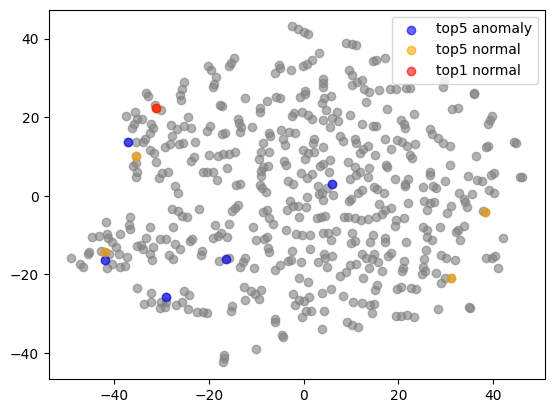

In [347]:
plt.scatter(*(repr_vecs_tsne.T), alpha=0.6, c="gray")

plt.scatter(*(repr_vecs_tsne[[68, 138, 279, 147, 105], :].T), alpha=0.6, c="blue", label="top5 anomaly")
plt.scatter(*(repr_vecs_tsne[[301, 354, 88, 488, 302], :].T), alpha=0.6, c="orange", label="top5 normal")
plt.scatter(*repr_vecs_tsne[301, :], alpha=0.6, c="red", label="top1 normal")
plt.legend()

In [896]:
embed_dim=128
arcface_family_conf = {"name":False}
class CustomWrapper(utils.MultiCropWrapper):
        def __init__(self, backbone, head):
            super(utils.MultiCropWrapper, self).__init__()
            self.backbone = backbone
            self.head = head
            
# teacher = ResNetMNIST(num_blocks=[2, 2, 2, 2], num_classes=embed_dim)
# teacher = torchvision_models.__dict__["resnet18"]()
teacher = myResNet(BasicBlock, [2,2,2,2])
teacher.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)
teacher.fc = nn.Linear(teacher.fc.in_features, out_features=embed_dim, bias=True)

teacher = CustomWrapper(
        teacher,
        DINOHead(embed_dim, 512, False, arcface_family_conf=arcface_family_conf,
            nlayers=3,
            hidden_dim=512,
            bottleneck_dim=128,
            ),
    )

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [925]:
teacher.cuda()
# # cp_path = "/workspace/puae/dino/outputs/test_PUMNIST_smallhead_kaggleResNet18_newaug/checkpoints/checkpoint.pth"
# cp_path = "/workspace/puae/dino/outputs/test_meancustomloss_lambda0to5/checkpoints/checkpoint.pth"
cp_path = "/workspace/puae/dino/outputs/test/emb_loss_4/checkpoints/checkpoint.pth"
utils.load_pretrained_weights(teacher, cp_path, "teacher", "ResNet", 16)
state_dict = torch.load(cp_path, map_location="cpu")["teacher"]
state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

def load_pretrained_backbone_head(model, cp_path, checkpoint_key="Teacher"):
    model.cuda()
    state_dict = torch.load(cp_path, map_location="cpu")["teacher"]
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    backbone_state = {k.replace("backbone.", ""):v for k,v in state_dict.items() if k.startswith("backbone")}
    head_state = {k.replace("head.", ""):v for k,v in state_dict.items() if k.startswith("head")}
    model.backbone.load_state_dict(backbone_state, strict=False)
    model.head.load_state_dict(head_state, strict=False)
    model.eval()
    # del teacher.head.last_layer

# if checkpoint_key is not None and checkpoint_key in state_dict:
#     print(f"Take key {checkpoint_key} in provided checkpoint dict")
#     state_dict = state_dict[checkpoint_key]
# # remove `module.` prefix
# state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
# # remove `backbone.` prefix induced by multicrop wrapper
# state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
# msg = model.load_state_dict(state_dict, strict=False)

Take key teacher in provided checkpoint dict
Pretrained weights found at /workspace/puae/dino/outputs/test/emb_loss_4/checkpoints/checkpoint.pth and loaded with msg: _IncompatibleKeys(missing_keys=['backbone.conv1.weight', 'backbone.bn1.weight', 'backbone.bn1.bias', 'backbone.bn1.running_mean', 'backbone.bn1.running_var', 'backbone.layer1.0.conv1.weight', 'backbone.layer1.0.bn1.weight', 'backbone.layer1.0.bn1.bias', 'backbone.layer1.0.bn1.running_mean', 'backbone.layer1.0.bn1.running_var', 'backbone.layer1.0.conv2.weight', 'backbone.layer1.0.bn2.weight', 'backbone.layer1.0.bn2.bias', 'backbone.layer1.0.bn2.running_mean', 'backbone.layer1.0.bn2.running_var', 'backbone.layer1.1.conv1.weight', 'backbone.layer1.1.bn1.weight', 'backbone.layer1.1.bn1.bias', 'backbone.layer1.1.bn1.running_mean', 'backbone.layer1.1.bn1.running_var', 'backbone.layer1.1.conv2.weight', 'backbone.layer1.1.bn2.weight', 'backbone.layer1.1.bn2.bias', 'backbone.layer1.1.bn2.running_mean', 'backbone.layer1.1.bn2.runnin

In [898]:
# state_dict.keys()
backbone_state = {k.replace("backbone.", ""):v for k,v in state_dict.items() if k.startswith("backbone")}
head_state = {k.replace("head.", ""):v for k,v in state_dict.items() if k.startswith("head")}
backbone_state.keys()

dict_keys(['conv1.weight', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.1.conv1.weight', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.num_batches_tracked', 'layer1.1.conv2.weight', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.num_batches_tracked', 'layer2.0.conv1.weight', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.num_batches_tracked', 'layer2.0.conv2.weight', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'l

In [899]:
teacher.backbone.load_state_dict(backbone_state, strict=False)
teacher.head.load_state_dict(head_state, strict=False)
teacher.eval()

CustomWrapper(
  (backbone): myResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [900]:
val_transform = transforms.Compose([
        # pth_transforms.Resize(256, interpolation=3),
        # pth_transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.ToPILImage()
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

local_transform = DataAugmentationDINOMNIST([0.8, 1.0], [0.4, 0.8], 8).local_transfo
val_dataset = datasets.MNIST(root="/workspace/puae/datasets", download=False, train=False, transform=val_transform)

# unl_train_subset, unl_val_subset, pos_train_subset, pos_val_subset = load(
pu_dataset, pu_val_dataset = load(
        name="MNIST",
        batch_size=False,
        normal_class=[1],
        unseen_anomaly=[0],
        labeled_anomaly_class=False, 
        n_train = 4500,
        n_valid = 500,
        # n_test = 2000,
        n_unlabeled_normal = 4500, #n_unlabeled_normal
        n_unlabeled_anomaly = 250, #n_unlabeled_anomaly
        n_labeled_anomaly = 250, #n_labeled_anomaly
        return_extra_test_loader= False,
        return_subset=True,
        return_unl_pos_subset=False, 
        transform = val_transform,
        seed=0, 
        return_id = False
        )

In [886]:
num_unlabel = 0
num_positive = 0
# for i in range(len(pu_val_dataset)):
#     if pu_val_dataset.__getitem__(i)[1]==0:
#         num_unlabel+=1
#     else: num_positive+=1

for i in range(len(pu_dataset)):
    if pu_dataset.__getitem__(i)[1]==0:
        num_unlabel+=1
    else: num_positive+=1

num_unlabel, num_positive

(4271, 229)

In [901]:
pu_loader = DataLoader(dataset=pu_dataset, batch_size=100, shuffle=False, num_workers=8,
           drop_last=False, pin_memory=True)
pu_val_loader = DataLoader(dataset=pu_val_dataset, batch_size=100, shuffle=False, num_workers=8,
           drop_last=False, pin_memory=True)

In [888]:
Counter([0,0,0,1,1])[1]

2

In [889]:
num_unlabel = 0
num_positive = 0
for _,i in tra_loader:
    i = i.tolist()
    c = Counter(i)
    num_unlabel+=c[0]
    num_positive+=c[1]

In [60]:
def get_repr_vec_ids(model, data1, data2, repr_vec_weight=None):
    num_unlabel = 0
    num_positive = 0
    # for i in range(len(dataset1)):
    #     if dataset1.__getitem__(i)[1]==0:
    #         num_unlabel+=1
    #     else: num_positive+=1

    # for i in range(len(dataset2)):
    #     if dataset2.__getitem__(i)[1]==0:
    #         num_unlabel+=1
    #     else: num_positive+=1

    num_unlabel = 0
    num_positive = 0
    for _,i in data1:
        i = i.tolist()
        c = Counter(i)
        num_unlabel+=c[0]
        num_positive+=c[1]
    for _,i in data2:
        i = i.tolist()
        c = Counter(i)
        num_unlabel+=c[0]
        num_positive+=c[1]

    pu_unlabel_vec_dict = defaultdict(float)
    pu_positive_vec_dict = defaultdict(float)

    #####
    for images, unl_pos in data1:
        images = images.cuda(non_blocking=True)
        if not repr_vec_weight:
            with torch.no_grad():
                output = model(images)[0][0]
        else:
            with torch.no_grad():
                output = repr_vec_weight(model.backbone(images))
        output =  output.cpu().detach()
        sorted_out, sorted_arg = torch.sort(output, dim=1, descending=True)
        sorted_out, sorted_arg = sorted_out.numpy()[:, :5], sorted_arg.numpy()[:, :5]
        for n, (out, arg) in enumerate(zip(sorted_out, sorted_arg)):
            if unl_pos[n] == 0:
                for o, a in zip(out, arg):
                    pu_unlabel_vec_dict[a] += o/num_unlabel
            elif unl_pos[n] == 1:
                for o, a in zip(out, arg):
                    pu_positive_vec_dict[a] += o/num_positive
            else: raise NotImplementedError
    
    for images, unl_pos in data2:
        images = images.cuda(non_blocking=True)
        if not repr_vec_weight:
            with torch.no_grad():
                output = model(images)[0][0]
        else:
            with torch.no_grad():
                output = repr_vec_weight(model.backbone(images))
        output =  output.cpu().detach()
        sorted_out, sorted_arg = torch.sort(output, dim=1, descending=True)
        sorted_out, sorted_arg = sorted_out.numpy()[:, :5], sorted_arg.numpy()[:, :5]
        for n, (out, arg) in enumerate(zip(sorted_out, sorted_arg)):
            if unl_pos[n] == 0:
                for o, a in zip(out, arg):
                    pu_unlabel_vec_dict[a] += o/num_unlabel
            elif unl_pos[n] == 1:
                for o, a in zip(out, arg):
                    pu_positive_vec_dict[a] += o/num_positive
            else: raise NotImplementedError

    #####

    # for i in range(len(dataset1)):
    #     sample_img, unl_pos = dataset1.__getitem__(i)
    #     sample_img = torch.unsqueeze(sample_img,0).cuda(non_blocking=True)
    #     if not repr_vec_weight:
    #         with torch.no_grad():
    #             output = model(sample_img)[0][0]
    #     else:
    #         with torch.no_grad():
    #             output = repr_vec_weight(model.backbone(sample_img)[0])
    #     output =  output.cpu().detach()
    #     sorted_out, sorted_arg = torch.sort(output, descending=True)
    #     sorted_out, sorted_arg = sorted_out.numpy()[:5], sorted_arg.numpy()[:5]
    #     for out, arg in zip(sorted_out, sorted_arg):
    #         if unl_pos == 0:
    #             pu_unlabel_vec_dict[arg] += out/num_unlabel
    #         elif unl_pos == 1:
    #             pu_positive_vec_dict[arg] += out/num_positive
    #         else: raise NotImplementedError

    # for i in range(len(dataset2)):
    #     sample_img, unl_pos = dataset2.__getitem__(i)
    #     sample_img = torch.unsqueeze(sample_img,0).cuda(non_blocking=True)
    #     if not repr_vec_weight:
    #         with torch.no_grad():
    #             output = model(sample_img)[0][0]
    #     else:
    #         with torch.no_grad():
    #             output = repr_vec_weight(model.backbone(sample_img)[0])
    #     output =  output.cpu().detach()
    #     sorted_out, sorted_arg = torch.sort(output, descending=True)
    #     sorted_out, sorted_arg = sorted_out.numpy()[:5], sorted_arg.numpy()[:5]
    #     for out, arg in zip(sorted_out, sorted_arg):
    #         if unl_pos == 0:
    #             pu_unlabel_vec_dict[arg] += out/num_unlabel
    #         elif unl_pos == 1:
    #             pu_positive_vec_dict[arg] += out/num_positive
    #         else: raise NotImplementedError

    pu_unlabel_vec_dict = dict(sorted(pu_unlabel_vec_dict.items(), key=lambda x: x[1], reverse=True))
    pu_positive_vec_dict = dict(sorted(pu_positive_vec_dict.items(), key=lambda x: x[1], reverse=True))
    pu_normal_repr_dict = pu_unlabel_vec_dict.copy()

    for k in pu_positive_vec_dict:
        if k in pu_normal_repr_dict.keys():
            pu_normal_repr_dict[k] -= pu_positive_vec_dict[k]

    pu_normal_repr_dict = dict(sorted(pu_normal_repr_dict.items(), key=lambda x: x[1], reverse=True))
    pu_normal_repr_dict_id = list(pu_normal_repr_dict.keys())[0]
    return  pu_unlabel_vec_dict, pu_positive_vec_dict, pu_normal_repr_dict, pu_normal_repr_dict_id


In [921]:
pu_unlabel_vec_dict, pu_positive_vec_dict, pu_normal_repr_dict, pu_normal_repr_dict_id = get_repr_vec_ids(teacher, pu_dataset, pu_val_dataset, repr_vec_weight=repr_vec_weight)
# pu_unlabel_vec_dict, pu_positive_vec_dict, pu_normal_repr_dict, pu_normal_repr_dict_id = get_repr_vec_ids(teacher, pu_loader, pu_val_loader, repr_vec_weight=repr_vec_weight)

In [375]:
pu_normal_repe_dict = pu_unlabel_vec_dict.copy()

for k in pu_positive_vec_dict:
    if k in pu_normal_repe_dict.keys():
        pu_normal_repe_dict[k] -= pu_positive_vec_dict[k]

pu_normal_repe_dict = dict(sorted(pu_normal_repe_dict.items(), key=lambda x: x[1], reverse=True))
pu_normal_repe_dict_id = list(pu_normal_repe_dict.keys())[0]
pu_normal_repe_dict


{149: 0.4094275803048356,
 140: 0.3675483305309161,
 302: 0.3385358584640828,
 104: 0.3266159218424246,
 138: 0.29994795536994917,
 87: 0.04877748347622737,
 192: 0.008955719328240158,
 354: 0.0020183488538390707,
 37: 0.0008415218999511317,
 95: 0.0005382753532183798,
 0: 8.868103278310676e-05,
 62: 1.9138753414154054e-05,
 30: -9.263553117450915e-06,
 447: -0.00041243910005217196,
 497: -0.000729732975363731,
 118: -0.0011289546458344711,
 438: -0.00149601733762967,
 376: -0.0016832747863311515,
 505: -0.0018522764989419979,
 225: -0.0028553035321988557,
 110: -0.00492464569681569,
 338: -0.012496826858112686,
 99: -0.012962073751872305,
 205: -0.02891447169921901,
 389: -0.03562217943723264,
 157: -0.04260860791959262,
 284: -0.058778018080874475,
 344: -0.060936026821010965}

In [976]:
targets = val_dataset.targets
ids = [0,1,2,3,4,5,6,7,8,9]
class ths_func(object):
    def __init__(self, lower, upper):
        self.lower = lower
        self.upper = upper
    def __call__(self, x):
        if x < self.lower: return 0
        elif x > self.upper: return 1
        else: return (x - self.lower) / (self.upper - self.lower)

# for i in ids:
#     tar_indices = (targets==0).nonzero()[:10].flatten()
    # for tar_id in tar_indices:

from collections import defaultdict
normal_vec_dict = defaultdict(float)

class_repr_vec = defaultdict(list)

repr_vec_list=[]
emb_list=defaultdict(list)
plt.figure(figsize=(20,20))

# tar_indices = (targets==1).nonzero()[:].flatten()
tar_indices = []
for i in range(10):
    tar_indices += random.sample((targets==i).nonzero().flatten().tolist(), 50)
# tar_indices = torch.arange(len(val_dataset))

ths_proj = ths_func(0.6, 0.8)

plot_num = 0
for n, tar_id in enumerate(tar_indices):
    sample_img, sample_id = val_dataset.__getitem__(tar_id)
    sample_img = torch.unsqueeze(sample_img,0).cuda(non_blocking=True)
    with torch.no_grad():
        output = teacher.backbone(sample_img)[0]
        emb_list[sample_id].append(output)

        out = repr_vec_weight(output).cpu().detach()
        sorted_out, sorted_arg = torch.sort(out, descending=True)
        sorted_out, sorted_arg = sorted_out.numpy()[:5], sorted_arg.numpy()[:5]
        for out, arg in zip(sorted_out, sorted_arg):
            normal_vec_dict[arg] += out #ths_proj(out)
        class_repr_vec[sample_id].append(dict(zip(sorted_arg, sorted_out)))


    # output =  output.cpu().detach().numpy()
    # repr_vec = np.argsort(output)[::-1][:20]
    # repr_vec_list.append(repr_vec)

    # output =  output.cpu().detach()
    # sorted_out, sorted_arg = torch.sort(output, descending=True)
    # sorted_out, sorted_arg = sorted_out.numpy()[:5], sorted_arg.numpy()[:5]
    # # for out, arg in zip(sorted_out, sorted_arg):
    # #     normal_vec_dict[arg] += out #ths_proj(out)
    # class_repr_vec[sample_id].append(dict(zip(sorted_arg, sorted_out)))
    
    # with torch.no_grad():
    #     output = teacher(sample_img, return_emb=True)[0]
    #     emb_list[sample_id].append(output)


#     if random.random() < 0.1:
#         plt.subplot(10, 1, plot_num+1)
#         plt.bar(list(range(len(output)))[:], output[:], label=f"dataset index:{tar_id}")
#         plt.ylim([-0.1, 1.0])
#         plt.title(f"top10: {repr_vec[:10]}")
#         plt.legend()
#         plot_num+=1
#         if plot_num==10: break
#     # plt.tick_params(labelbottom=False)
# plt.suptitle(f"id:{sample_id}")
# plt.tight_layout()

<Figure size 2000x2000 with 0 Axes>

In [975]:
repr_vec_weight = nn.utils.weight_norm(nn.Linear(128, 100, bias=False)).cuda()
repr_vec_weight.weight_g.data.fill_(1)
repr_vec_weight.weight_g.requires_grad = False
state_repr_vec = torch.load("/workspace/puae/dino/outputs/test/emb_loss_4/checkpoints/checkpoint.pth", map_location="cpu")["t_repr_vec"]
repr_vec_weight.load_state_dict(state_repr_vec)
repr_vec_weight.eval()
# reprrepr_vec_weight_vec(torch.eye(128).cuda())

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Linear(in_features=128, out_features=100, bias=False)

In [977]:
emb_numpy = torch.vstack(sum(list(emb_list.values()), [])).cpu().detach().numpy()
repr_vec_numpy = repr_vec_weight.weight.data.cpu().detach().numpy()[:]

emb_repr_numpy = np.vstack([emb_numpy, repr_vec_numpy])
tsne = TSNE(n_components=2, random_state = 0, perplexity = 10, n_iter = 1000)
emb_tsne = tsne.fit_transform(emb_repr_numpy)

In [978]:
emb_tsne.__len__()

600

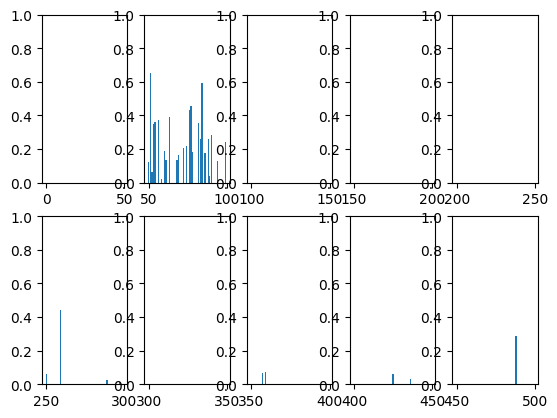

In [979]:
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.bar(np.arange(i*50, (i+1)*50), (emb_numpy @ repr_vec_numpy.T)[i*50:(i+1)*50, 35])
    plt.ylim(0,1.)


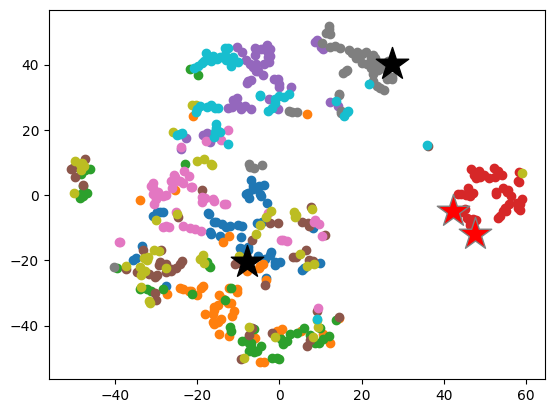

In [980]:
colors = ["#1f77b4","#d62728","#ff7f0e","#2ca02c","#9467bd",
        "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf",]
for i in range(10):
    plt.scatter(*(emb_tsne[i*50:(i+1)*50].T), color=colors[i])
##代表ベクトルもプロットする　つまりtsneに代表ベクトルを加えて計算
# plt.scatter(*emb_tsne[-5], marker="*", color="red")
# plt.scatter(*emb_tsne[-4], marker="*", color="red")
# plt.scatter(*emb_tsne[-3], marker="*", color="red")
# plt.scatter(*emb_tsne[-2], marker="*", color="red")
# plt.scatter(*emb_tsne[-1], marker="*", color="red")
# for i in range(500,600):
#     plt.scatter(*emb_tsne[i], marker="*", color="red")
plt.scatter(*emb_tsne[500+10], marker="*", s=600,color="black")
plt.scatter(*emb_tsne[500+27], marker="*", s=600,color="red", edgecolors="gray")
# plt.scatter(*emb_tsne[500+33], marker="*", color="red")
plt.scatter(*emb_tsne[500+35], marker="*", s=600, color="red", edgecolors="gray")
plt.scatter(*emb_tsne[500+92], marker="*", s=600, color="black")

In [835]:
def get_repr_rank(class_repr_vec):
    repr_rank = defaultdict(lambda: [0, 0])
    for i in class_repr_vec:
        for k,v in i.items():
            repr_rank[k] = [repr_rank[k][0]+1, repr_rank[k][1]+v] 

    repr_rank = dict(sorted(repr_rank.items(), key=lambda x: x[1][1], reverse=True))
    return repr_rank
repr_rank = get_repr_rank(class_repr_vec[3])

In [836]:
repr_indices = set()
for i in range(10):
    repr_indices = repr_indices | set(np.unique(np.concatenate([list(d.keys()) for d in class_repr_vec[i]])))
repr_indices = [str(i) for i in sorted(list(repr_indices))]

class id: 0
(92, [50, 30.580689877271652])
(10, [50, 19.23345172405243])
(34, [34, 9.444141447544098])
(31, [29, 5.619696170091629])
(27, [19, 4.663616299629211])
class id: 1
(27, [18, 7.730616718530655])
(35, [16, 6.714889213442802])
(33, [15, 5.112804815173149])
(69, [16, 4.980361968278885])
(34, [21, 4.810899347066879])
class id: 2
(92, [50, 31.088617384433746])
(10, [50, 17.9419162273407])
(34, [45, 15.207091137766838])
(31, [35, 7.101582780480385])
(81, [25, 6.510663077235222])
class id: 3
(92, [50, 27.994122117757797])
(34, [50, 20.585291504859924])
(10, [50, 15.219403699040413])
(81, [41, 12.195425555109978])
(31, [16, 3.053915724158287])
class id: 4
(65, [50, 25.139784038066864])
(10, [50, 18.93918079137802])
(81, [43, 12.686853557825089])
(41, [34, 7.432902470231056])
(92, [23, 6.420593053102493])
class id: 5
(92, [50, 31.063449501991272])
(10, [49, 16.205221757292747])
(34, [44, 14.050765410065651])
(81, [22, 5.281812131404877])
(40, [22, 4.261561542749405])
class id: 6
(92, 

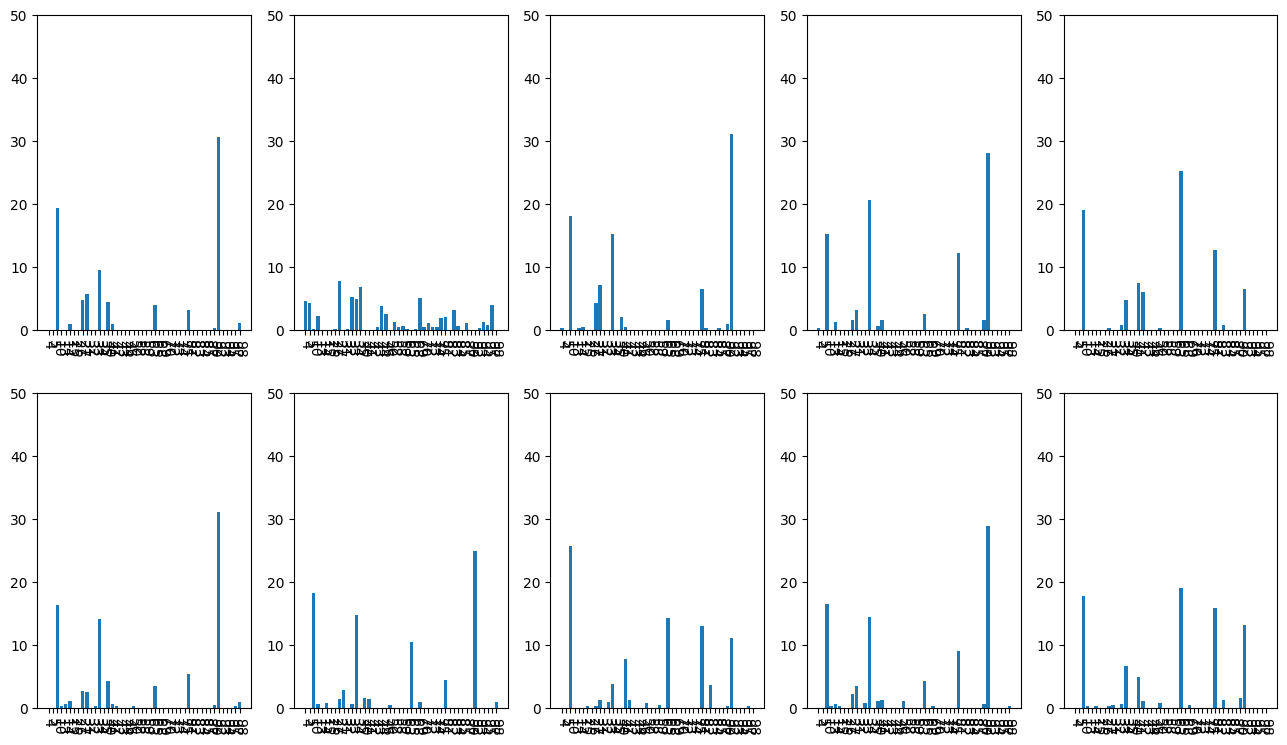

In [837]:
plt.figure(figsize=(16,9))
for n in range(10):
    print(f"class id: {n}")
    repr_rank = get_repr_rank(class_repr_vec[n])
    print(*list(repr_rank.items())[:5], sep="\n")
    plt.subplot(2,5,n+1)
    plt.bar(repr_indices, [0 if int(i) not in repr_rank else repr_rank[int(i)][1] for i in repr_indices])
    plt.ylim(0, 50)
    plt.xticks(rotation=-90)

In [387]:
repr_vec_list[2], repr_vec_list[6], repr_vec_list[8]

(array([1738, 1122,  463, 1284,    8, 1589, 1451,  687,  980, 1823, 1703,
        1341,  211, 1164,  141, 1537,  939,  487,  705, 1706]),
 array([1738, 1284,    8, 1589,  980, 1703,  487,  463, 1341, 1843,  341,
        1164, 1175,  527, 1757, 1882, 1632,  237,  369, 1058]),
 array([1738,    8, 1284, 1589, 1703, 1058,  463,  980,  527, 1605,  141,
         211,  687,  487, 1682, 1882,  939,  542,  237, 1867]))

In [731]:
from collections import Counter
print(*repr_vec_list, sep="\n")
repr_dict = Counter(np.concatenate(repr_vec_list).tolist())
repr_dict = {k:v for k,v in repr_dict.items()}
repr_dict = dict(sorted(repr_dict.items(), key=lambda x:x[1], reverse=True))
print(len(repr_vec_list))
print(*repr_dict.items(), sep="\n")

ValueError: need at least one array to concatenate

In [282]:
top5_normal_repr_ids = list(pu_normal_repr_dict.keys())[:5]
top5_normal_repr_vecs= head_state["last_layer.weight_v"][top5_normal_repr_ids,:]
top5_normal_repr_vecs= nn.functional.normalize(top5_normal_repr_vecs, dim=1)
print(f"代表ベクトルのshape: {top5_normal_repr_vecs.shape}, norm: {top5_normal_repr_vecs.norm(dim=1, p=2)}")
top5_normal_repr_wights = list(pu_normal_repr_dict.values())[:5]

代表ベクトルのshape: torch.Size([5, 128]), norm: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [315]:
(top5_normal_repr_vecs @ head_emb)

tensor([-0.1915, -0.1580, -0.1238, -0.1043, -0.1050])

In [312]:
nn.functional.softmax(torch.tensor(top5_normal_repr_wights)/0.1, dim=0, dtype=torch.float32)

torch.float32

In [686]:
repr_vec_weight.weight.data

tensor([[-0.0897,  0.0457,  0.1317,  ..., -0.0134,  0.1433,  0.0460],
        [ 0.1462, -0.0155, -0.0380,  ..., -0.0351, -0.1165,  0.1220],
        [-0.0906,  0.0841,  0.0678,  ..., -0.0759, -0.1430, -0.0441],
        ...,
        [ 0.0809, -0.0958,  0.1082,  ..., -0.0142,  0.0647, -0.1039],
        [ 0.0996, -0.1209,  0.0285,  ...,  0.0027,  0.1700,  0.0946],
        [-0.0225,  0.1052, -0.1137,  ...,  0.0683, -0.0842,  0.0561]],
       device='cuda:0')

In [689]:
nn.functional.normalize(repr_vec_weight.weight_v, dim=1)

tensor([[-0.0897,  0.0457,  0.1317,  ..., -0.0134,  0.1433,  0.0460],
        [ 0.1462, -0.0155, -0.0380,  ..., -0.0351, -0.1165,  0.1220],
        [-0.0906,  0.0841,  0.0678,  ..., -0.0759, -0.1430, -0.0441],
        ...,
        [ 0.0809, -0.0958,  0.1082,  ..., -0.0142,  0.0647, -0.1039],
        [ 0.0996, -0.1209,  0.0285,  ...,  0.0027,  0.1700,  0.0946],
        [-0.0225,  0.1052, -0.1137,  ...,  0.0683, -0.0842,  0.0561]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [722]:
repr_vec_weight.weight.data.norm(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0')

In [724]:
repr_vec_weight.weight.data.norm(dim=1)

tensor([0.6153, 0.5754, 0.5977, 0.5559, 0.6042, 0.5711, 0.5648, 0.5610, 0.5668,
        0.5688, 0.5883, 0.5694, 0.5613, 0.5908, 0.5558, 0.5560, 0.5962, 0.5728,
        0.5988, 0.5662, 0.5589, 0.5659, 0.5753, 0.6172, 0.5856, 0.5535, 0.6093,
        0.5871, 0.5859, 0.5699, 0.5828, 0.5631, 0.5773, 0.5546, 0.6539, 0.6183,
        0.6001, 0.5524, 0.5989, 0.5740, 0.5593, 0.5982, 0.5887, 0.5897, 0.5939,
        0.5640, 0.5565, 0.5934, 0.5760, 0.5632, 0.5419, 0.5732, 0.5816, 0.5660,
        0.5543, 0.6074, 0.5753, 0.5431, 0.5982, 0.5717, 0.5879, 0.5806, 0.5137,
        0.5446, 0.5788, 0.5433, 0.5886, 0.5638, 0.5889, 0.5863, 0.6105, 0.5813,
        0.5602, 0.5604, 0.5766, 0.5825, 0.6045, 0.5587, 0.5601, 0.5635, 0.5725,
        0.5637, 0.6204, 0.5797, 0.5686, 0.5767, 0.5606, 0.5569, 0.5891, 0.5723,
        0.5757, 0.5501, 0.5963, 0.5783, 0.5714, 0.5909, 0.5778, 0.5824, 0.5175,
        0.6125], device='cuda:0')

In [718]:
# t = torch.randn(1,128).cuda(non_blocking=True)
with torch.no_grad():
    r = repr_vec_weight(t)
    r_ = t @ repr_vec_weight.weight.data.T
r_.data[0]

tensor([-0.8287, -0.0667, -1.1339, -0.3351,  0.3890, -2.2808,  0.6977,  0.6895,
         0.0218,  2.2305, -0.3383, -0.5206,  0.3663,  0.1879,  0.1172,  0.5992,
        -0.5654,  0.1918, -2.5034,  0.6940,  2.3579, -0.9696, -0.1318, -0.3673,
         2.3618, -0.0845,  0.9839, -1.3733, -1.0578,  0.3529,  1.0153,  1.5081,
        -0.0076, -1.2290,  0.5961, -1.0230, -0.7119, -0.1160,  0.7174,  0.8503,
         0.6122,  1.2965, -2.2079,  0.0989,  1.3053,  0.7875, -0.3320,  1.5120,
         0.2073, -1.7179, -0.3992,  0.0489, -0.3707, -2.1467,  0.2535,  0.8690,
        -1.7076,  0.0537,  1.5586,  0.9504,  0.9211, -0.4541, -1.1614,  1.5375,
         0.4071,  0.3687, -1.4431, -0.7230,  2.1533,  1.1521, -1.2927,  0.6385,
         0.6719, -0.0786, -0.4425, -1.0160, -0.7841,  1.8054,  0.5306,  0.0029,
        -1.1284, -0.7699, -1.0726, -0.3718, -1.0648,  0.1402, -0.3854, -0.9772,
         1.5527, -0.7056,  1.3567,  1.1975,  0.0741, -0.3530,  1.2928, -0.0273,
        -0.3735, -0.6670,  0.3646, -0.34

In [758]:
list(pu_normal_repr_dict.keys())[:5]

[27, 35, 4, 69, 33]

In [822]:
def select_unique_random_indices(arr):
    # ユニークな要素を取得
    unique_elements = set(arr)
    
    # ユニークな要素のインデックスを保持する辞書
    unique_indices = defaultdict(list)
    for index, value in enumerate(arr):
        unique_indices[value].append(index)
    
    print(unique_indices)
    unique_indices = dict(sorted(unique_indices.items(), key=lambda x:x[0]))
    print(unique_indices)
    # ユニークな要素からランダムにインデックスを選択
    # selected_indices = [unique_indices[element] for element in random.sample(list(unique_elements), len(unique_elements))]
    selected_indices = {k:random.choice(list(v)) for k,v in unique_indices.items()}

    return selected_indices

# 使用例
arr = [3, 1, 4, 1, 5, 9, 2, 6, 5, 3, 5]
result = select_unique_random_indices(arr)
print(result)
for class_id, index in result.items():
    print(class_id, index)

defaultdict(<class 'list'>, {3: [0, 9], 1: [1, 3], 4: [2], 5: [4, 8, 10], 9: [5], 2: [6], 6: [7]})
{1: [1, 3], 2: [6], 3: [0, 9], 4: [2], 5: [4, 8, 10], 6: [7], 9: [5]}
{1: 3, 2: 6, 3: 9, 4: 2, 5: 4, 6: 7, 9: 5}
1 3
2 6
3 9
4 2
5 4
6 7
9 5


### AUROC

In [74]:
# del teacher.head.last_layer
#代表ベクトル
# normal_repr_vec = head_state["last_layer.weight_v"][6,:]
# normal_repr_vec = head_state["last_layer.weight_v"][369,:]
def calc_y_score(model, val_dataset, pu_normal_repr_dict_id, pu_unlabel_vec_dict, pu_positive_vec_dict, pu_normal_repr_dict, repr_vec_weight=None):
    # normal_repr_vec = head_state["last_layer.weight_v"][pu_normal_repr_dict_id,:]
    if not repr_vec_weight:
        normal_repr_vec = model.head.last_layer.weight_v.detach().cpu().clone()[pu_normal_repr_dict_id,:]
        normal_repr_vec /= torch.norm(normal_repr_vec, p=2)
    else:
        normal_repr_vec = repr_vec_weight.weight.data.detach().cpu().clone()[pu_normal_repr_dict_id,:]
        # normal_repr_vec = repr_vec_weight.weight.data.detach().cpu().clone()
    print(f"正常代表ベクトルのshape: {normal_repr_vec.shape}, norm: {normal_repr_vec.norm(p=2)}")

    ################
    top5_normal_repr_ids = list(pu_normal_repr_dict.keys())[:5]
    # top5_normal_repr_ids = list(pu_unlabel_vec_dict.keys())[:5]
    # top5_positive_repr_ids = list(pu_positive_vec_dict.keys())[:5]
    # top5_normal_repr_ids = [i for i in top5_normal_repr_ids if i not in top5_positive_repr_ids]

    # top5_normal_repr_vecs= head_state["last_layer.weight_v"][top5_normal_repr_ids,:]
    if not repr_vec_weight:
        top5_normal_repr_vecs= model.head.last_layer.weight_v.detach().cpu().clone()[top5_normal_repr_ids,:]
        top5_normal_repr_vecs= nn.functional.normalize(top5_normal_repr_vecs, dim=1)
    else:
        top5_normal_repr_vecs = repr_vec_weight.weight.data.detach().cpu().clone()[top5_normal_repr_ids,:]
    print(f"(top5正常代表ベクトルのindex: {top5_normal_repr_ids}")
    print(f"top5正常代表ベクトルのshape: {top5_normal_repr_vecs.shape}, norm: {top5_normal_repr_vecs.norm(dim=1, p=2)}")
    top5_normal_repr_wights = list(pu_normal_repr_dict.values())[:5]
    print(f"top5_normal_repr_weights: {top5_normal_repr_wights}")
    top5_normal_repr_wights = nn.functional.softmax(torch.tensor(top5_normal_repr_wights)/0.1, dim=0, dtype=torch.float32)
    print(f"top5_normal_repr_softmax_weights: {top5_normal_repr_wights}")
    ################

    random.seed(42)
    #正常データのindex 
    try: indices = val_dataset.targets
    except: indices = val_dataset.labels
    

    if not torch.is_tensor(indices):
        indices = torch.tensor(indices)
    normal_indices = (indices==1).nonzero().flatten()
    normal_indices = random.sample(normal_indices.tolist(), 1000)
    #異常データのindex
    anomaly_indices = (indices!=1).nonzero().flatten()
    anomaly_indices = random.sample(anomaly_indices.tolist(), 1000)

    #結果の配列
    y_true = []
    y_score = []
    y_each_class = defaultdict(list)

    for i in range(len(val_dataset)):
        if i in normal_indices:
            y_true.append(0)
        elif i in anomaly_indices:
            y_true.append(1)
        # else: continue
        sample, id = val_dataset.__getitem__(i)
        sample = sample.unsqueeze(0)
        if not repr_vec_weight:
            with torch.no_grad():
                head_emb = model(sample.cuda(non_blocking=True), return_emb=True)[0].cpu()
                head_emb = nn.functional.normalize(head_emb.unsqueeze(0), p=2)[0]
                score = (normal_repr_vec @ head_emb).item()
                if i in normal_indices or i in anomaly_indices:
                    y_score.append(score)
                y_each_class[id].append(score)
        else:
            with torch.no_grad():
                backbone_emb = model.backbone(sample.cuda(non_blocking=True))[0].cpu()
                # y_score.append(((normal_repr_vec @ backbone_emb).item()))

                score = (top5_normal_repr_vecs @ backbone_emb).mean().item() #meanではなくmaxも試す
                # score = (top5_normal_repr_vecs @ backbone_emb).max().item() #meanではなくmaxも試す
                if i in normal_indices or i in anomaly_indices:
                    y_score.append(score)
                # y_score.append( ((top5_normal_repr_vecs @ backbone_emb) @ top5_normal_repr_wights).item())

                # backbone_emb = model.backbone(sample.cuda(non_blocking=True))[0]
                # sf_out = nn.functional.softmax(repr_vec_weight(backbone_emb)).cpu()
                # y_score.append(sf_out[pu_normal_repr_dict_id])
                y_each_class[id].append(score)

        ##################
        # y_score.append((top5_normal_repr_vecs @ head_emb).mean().item())
        # y_score.append( ((top5_normal_repr_vecs @ head_emb) @ top5_normal_repr_wights).item())
        ##################

    y_score = np.array(y_score)
    y_score = (y_score - y_score.min()) / (y_score.max() - y_score.min())
    y_score = 1 - y_score
    y_each_class = dict(sorted(y_each_class.items(), key=lambda x: x[0]))
    return y_true, y_score, y_each_class

In [27]:
import numpy as np
loss = np.array([[ 1,         -0.40429688, -0.17675781, -0.21875,    -0.20605469],
 [-0.40429688,  1.         ,-0.50390625, -0.02734375, -0.06347656],
 [-0.17675781, -0.50390625,  1.         ,-0.05395508, -0.24804688],
 [-0.20605469, -0.06347656, -0.24804688, -0.5859375,   1.        ],
 [-0.21875,    -0.02734375, -0.05395508,  1.        , -0.5859375 ]])
((loss+1)/2).sum()

12.5114746

In [1043]:
y_true, y_score, y_each_class = calc_y_score(teacher, val_dataset, pu_normal_repr_dict_id, pu_unlabel_vec_dict, pu_positive_vec_dict, pu_normal_repr_dict, repr_vec_weight)

正常代表ベクトルのshape: torch.Size([128]), norm: 0.9999999403953552
(top5正常代表ベクトルのindex: [35, 27, 4, 69, 33]
top5正常代表ベクトルのshape: torch.Size([5, 128]), norm: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000])
top5_normal_repr_weights: [0.1054683235428833, 0.10437784337683695, 0.09330941577961573, 0.08468931680604022, 0.08096645152882517]
top5_normal_repr_softmax_weights: tensor([0.2237, 0.2213, 0.1981, 0.1818, 0.1751])


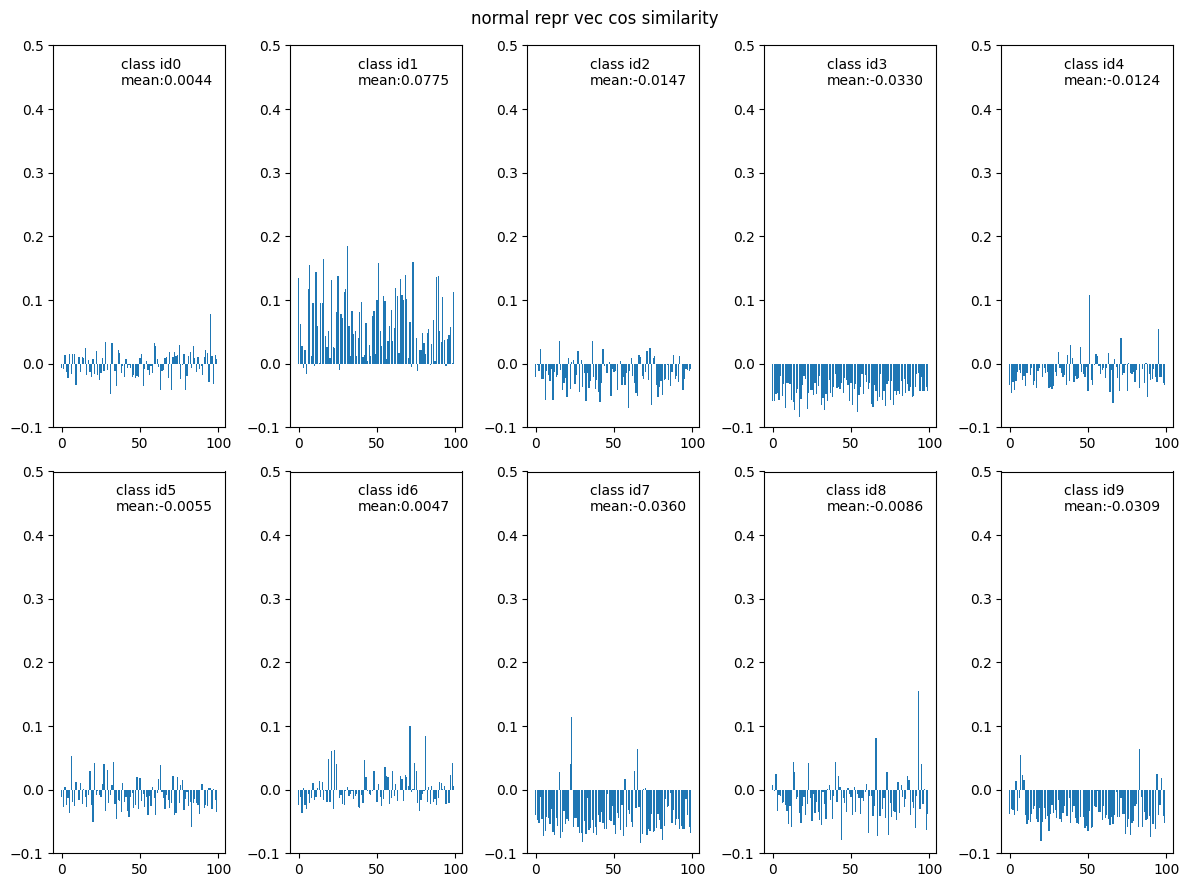

In [1076]:
def plot_class_scores(y_each_class):
    plt.figure(figsize=(12,9))
    for n, (k, v) in enumerate(y_each_class.items()):
        plt.subplot(2,5, n+1)
        plt.bar(np.arange(len(v))[:100], v[:100], label=f"class id{k}\nmean:{np.mean(v):.4f}")
        plt.ylim(-0.1,0.5)
        plt.legend(handlelength=0, frameon=False)
    plt.suptitle("normal repr vec cos similarity")
    plt.tight_layout()
plot_class_scores(y_each_class)

In [841]:
for n, (t, s) in enumerate(zip(y_true, y_score)):
    print(t, s)
    if n == 9: break

0 0.22687276702073833
0 0.4846329333350493
0 0.6076242424848359
1 0.7489187457196411
1 0.7879599494552039
0 0.730165836418418
0 0.7642226373721981
0 0.2892489829511026
0 0.1521871988991228
0 0.6658572584941624


0.9431889999999999

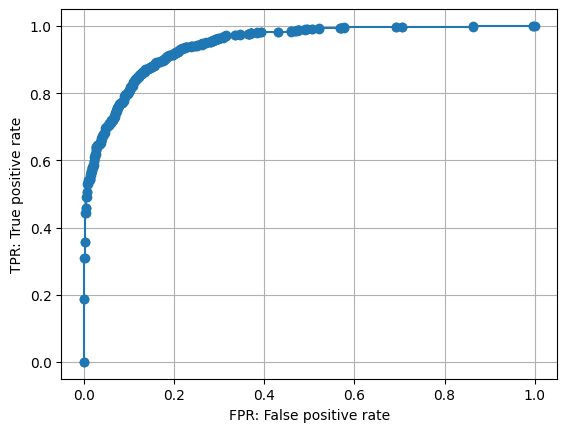

In [842]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
roc_auc_score(y_true, y_score)

In [156]:
from sklearn.metrics import confusion_matrix
conf_score = np.copy(y_score)
conf_score = np.where(conf_score>0.8, 1, conf_score).astype(int)
print(confusion_matrix(y_true, conf_score.tolist()))

[[839 161]
 [155 845]]


### 埋め込みの強化

In [537]:
#異常データの代表ベクトル
anomaly_repr_vec_indices = [1738, 1757, 1578, 8, 1284]
anomaly_repr_vec_indices = [201, 199, 223, 54, 237]
anomaly_repr_vec = {}

for i in anomaly_repr_vec_indices:
    w = head_state["last_layer.weight_v"][i,:]
    anomaly_repr_vec[i] = w / torch.norm(w, p=2)


In [524]:
anomaly_repr_vec.values()

dict_values([tensor([ 0.1309,  0.0055, -0.1750,  0.1074, -0.1748,  0.0617,  0.1601, -0.0164,
        -0.0714,  0.1249, -0.1370,  0.0198, -0.0316,  0.0902, -0.0951,  0.1030,
         0.0246,  0.1093, -0.0860,  0.0705, -0.1002,  0.0658,  0.1645, -0.0909,
         0.0361, -0.0205, -0.0744,  0.0030,  0.0582, -0.0857, -0.0863, -0.0161,
        -0.1333, -0.0337,  0.1458,  0.0433,  0.1249,  0.0467,  0.0060,  0.0188,
         0.1081,  0.1691, -0.0755,  0.1072,  0.0108,  0.0343,  0.1384, -0.1239,
        -0.0637,  0.0513,  0.0493, -0.0401, -0.1597, -0.0698, -0.1007,  0.0256,
        -0.0394, -0.0970, -0.1062,  0.1048,  0.1054, -0.0450, -0.0047, -0.0635,
        -0.1532, -0.0770, -0.1052,  0.1252,  0.0029,  0.0116,  0.1096, -0.1075,
         0.1428,  0.0404,  0.0794,  0.0747,  0.1429,  0.0778, -0.0398, -0.1065,
        -0.0854, -0.0818,  0.0036,  0.0368,  0.1098,  0.0431, -0.0571, -0.0673,
        -0.0697, -0.0294,  0.1139, -0.0515, -0.0612, -0.0427,  0.0275, -0.1409,
        -0.1013, -0.1486, -

In [538]:
import numpy as np

def update_vector_to_maximize_angle(a, others, weights=None, learning_rate=0.01, num_iterations=1000):
    """
    ベクトルaを、他のベクトルとの角度を最大化するように更新する関数
    
    Parameters:
    - a: 元のベクトル (norm = 1)
    - others: 他のベクトルのリスト (b, c, d, e)
    - learning_rate: 勾配更新の学習率
    - num_iterations: 勾配法の反復回数
    
    Returns:
    - 更新後のベクトルnew_a
    """
    if not isinstance(weights, np.ndarray):
        # return
        weights = np.ones(len(others))
    # 初期ベクトルをコピー
    new_a = a.copy()
    
    for _ in range(num_iterations):
        # 勾配を計算
        gradient = np.zeros_like(new_a)
        
        for other, w in zip(others, weights):
            # cos類似度を計算
            cos_similarity = np.dot(new_a, other) / (np.linalg.norm(new_a) * np.linalg.norm(other))
            # print((np.linalg.norm(new_a) * np.linalg.norm(other)))
            # cos類似度を最小化する勾配を計算
            gradient += w * cos_similarity * other
        
        # ベクトルを更新
        new_a -= learning_rate * gradient
        
        # ノルムを1に正規化
        new_a = new_a / np.linalg.norm(new_a)
    
    return new_a

# 使用例
np.random.seed(42)
a = normal_repr_vec.clone().detach().numpy() #正常データの代表ベクトル

# 他のベクトルを生成
b, c, d, e, f = [v.clone().detach().numpy() for v in anomaly_repr_vec.values()] #異常データの代表ベクトル
others = [b, c, d, e, f]
weights = nn.functional.softmax(torch.tensor([np.dot(a,i) for i in others]), dim=-1).numpy()
weights *= len(others)

# ベクトルaを更新
new_a = update_vector_to_maximize_angle(a, others, None)

# 更新前後の角度を比較
print("元のベクトルa:")
print(a)
print("\n更新後のベクトルnew_a:")
print(new_a)

# cos類似度の確認
print("\n更新前のcos類似度:")
for other in others:
    print(np.dot(a, other) / (np.linalg.norm(a) * np.linalg.norm(other)))

print("\n更新後のcos類似度:")
for other in others:
    print(np.dot(new_a, other) / (np.linalg.norm(new_a) * np.linalg.norm(other)))

元のベクトルa:
[-0.10786458  0.01235885  0.1293771   0.0637665   0.03879911 -0.05398167
 -0.08577856  0.1344109  -0.15107015 -0.05909749  0.01663789  0.07078378
 -0.04202624  0.13386919  0.15883663  0.07441134  0.10697636  0.00950396
  0.14154021  0.00867439 -0.13058227  0.13081355 -0.03193329 -0.02179922
 -0.02396187 -0.14270748  0.06750551  0.12295507 -0.10917621  0.04603959
  0.05885814 -0.04000615  0.07533006 -0.00642867  0.0151263  -0.00475298
  0.04208594 -0.06555843  0.11640672  0.03138535 -0.02595378 -0.09936763
 -0.01636111 -0.08512049  0.08675254 -0.01824779  0.12042412 -0.09930363
 -0.10585703  0.04138354 -0.03397927  0.05519851  0.02376328 -0.0071679
  0.13223867 -0.11690551  0.14873108  0.09913177 -0.02340903 -0.21020046
  0.0927477   0.09926645 -0.09050928  0.13425332 -0.04761831  0.056972
 -0.13851826 -0.01153254 -0.05389351 -0.07953043 -0.09973133 -0.05764647
 -0.06140643  0.13597642 -0.05965377 -0.04396813 -0.01866787  0.10069325
 -0.14702857 -0.0372241  -0.05106577 -0.06241

In [539]:
a[:10], normal_repr_vec[:10], torch.from_numpy(new_a[:10]), normal_repr_vec @ torch.from_numpy(new_a)

(array([-0.10786458,  0.01235885,  0.1293771 ,  0.0637665 ,  0.03879911,
        -0.05398167, -0.08577856,  0.1344109 , -0.15107015, -0.05909749],
       dtype=float32),
 tensor([-0.1079,  0.0124,  0.1294,  0.0638,  0.0388, -0.0540, -0.0858,  0.1344,
         -0.1511, -0.0591]),
 tensor([-0.0706,  0.0625,  0.0892,  0.0869,  0.0063, -0.0938, -0.1297,  0.1264,
         -0.1638, -0.0652]),
 tensor(0.9324))

In [540]:
# del teacher.head.last_layer
#代表ベクトル
updated_normal_repr_vec = torch.from_numpy(new_a)
print(f"更新後の代表ベクトルのshape: {updated_normal_repr_vec.shape}")

#正常データのindex 
normal_indices = (val_dataset.targets==1).nonzero().flatten()
#異常データのindex
anomaly_indices = (val_dataset.targets!=1).nonzero().flatten()

#結果の配列
y_true = []
updated_y_score = []

for i in range(len(val_dataset)):
    if i in normal_indices:
        y_true.append(0)
    elif i in anomaly_indices:
        y_true.append(1)    
    sample = val_dataset.__getitem__(i)[0]
    sample = sample.unsqueeze(0)
    with torch.no_grad():
        head_emb = teacher(sample.cuda(non_blocking=True))[0].cpu()
    head_emb = nn.functional.normalize(head_emb.unsqueeze(0), p=2)[0]
    updated_y_score.append(((updated_normal_repr_vec @ head_emb).item()))

updated_y_score = np.array(updated_y_score)
updated_y_score = (updated_y_score - updated_y_score.min()) / (updated_y_score.max() - updated_y_score.min())
updated_y_score = 1- updated_y_score

更新後の代表ベクトルのshape: torch.Size([128])


In [541]:
print("更新後 <- 更新前")
for n, (t, u_s, s) in enumerate(zip(y_true, updated_y_score, y_score)):
    print(f"{t}, {u_s:.5f} <- {s:.5f},", end=" ")
    if t == 1:
        print(f"{u_s - s:.5f} 性能向上")
    if t == 0:
        print(f"{s - u_s:.5f} 性能向上")

    if n == 9: break

更新後 <- 更新前
1, 0.79985 <- 0.88414, -0.08429 性能向上
1, 0.83628 <- 0.79252, 0.04377 性能向上
0, 0.74072 <- 0.66864, -0.07208 性能向上
1, 0.88120 <- 0.81618, 0.06502 性能向上
1, 0.83938 <- 0.82303, 0.01635 性能向上
0, 0.68406 <- 0.55840, -0.12566 性能向上
1, 0.80451 <- 0.83913, -0.03461 性能向上
1, 0.76438 <- 0.66620, 0.09818 性能向上
1, 0.88235 <- 0.89050, -0.00815 性能向上
1, 0.79066 <- 0.85293, -0.06227 性能向上


0.8674514188599923
0.8700890747407889
-0.0026376558807965633


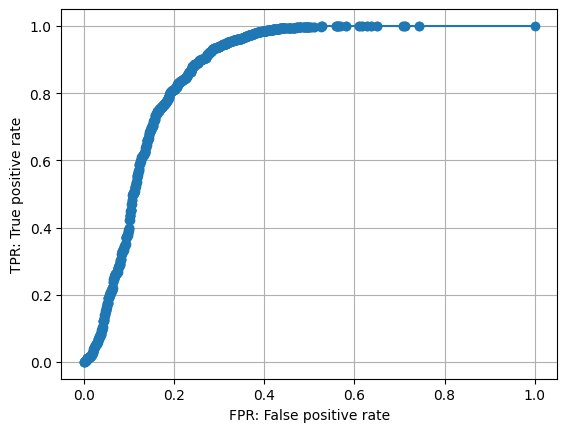

In [542]:
u_fpr, u_tpr, u_thresholds = roc_curve(y_true, updated_y_score)
plt.plot(u_fpr, u_tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
print(roc_auc_score(y_true, updated_y_score))
print(roc_auc_score(y_true, y_score))
print(roc_auc_score(y_true, updated_y_score) - roc_auc_score(y_true, y_score))

### 正常代表ベクトルを増やす

In [544]:
print("ラベルなしデータの代表ベクトル群")
for n, (k, v) in enumerate(pu_unlabel_vec_dict.items()):
    print(f"{k}: {v:.5f}")
    if n == 9: break

print("ラベルありpositiveデータの代表ベクトル群")
for n, (k, v) in enumerate(pu_positive_vec_dict.items()):
    print(f"{k}: {v:.5f}")
    if n == 19: break

print("ラベルなし-ラベルありpositiveデータの代表ベクトル群")
for n, (k, v) in enumerate(pu_normal_repe_dict.items()):
    print(f"{k}: {v:.5f}")
    if n == 9: break

sub_normal_repr_vec_indices = [959, 1758, 982]
sub_normal_repr_vec_indices = [414, 16, 162]

ラベルなしデータの代表ベクトル群
162: 0.23522
369: 0.22206
414: 0.19326
16: 0.17764
275: 0.16012
296: 0.14142
211: 0.13234
496: 0.11671
289: 0.08951
216: 0.07739
ラベルありpositiveデータの代表ベクトル群
201: 0.76092
199: 0.69079
223: 0.66272
54: 0.53180
237: 0.08933
185: 0.07948
162: 0.07943
267: 0.02421
275: 0.02130
413: 0.00398
414: 0.00382
184: 0.00221
18: 0.00192
310: 0.00141
324: 0.00113
ラベルなし-ラベルありpositiveデータの代表ベクトル群
369: 0.22206
414: 0.18943
16: 0.17764
162: 0.15579
296: 0.14142
275: 0.13881
211: 0.13234
496: 0.11671
289: 0.08951
216: 0.07739


### ラベルなしデータの中で6が低くかつ, ラベルあり上位の代表ベクトルが低いやつの代表ベクトルを見つける

In [552]:
pu_dataset_targets = []
for n, tar_id in enumerate(range(len(pu_dataset))):
    _, sample_id = pu_dataset.__getitem__(tar_id)
    pu_dataset_targets.append(sample_id)
pu_dataset_targets = np.array(pu_dataset_targets)

In [596]:
head_state["last_layer.weight_v"][369,:] @ head_state["last_layer.weight_v"][162,:]

tensor(-0.0633)

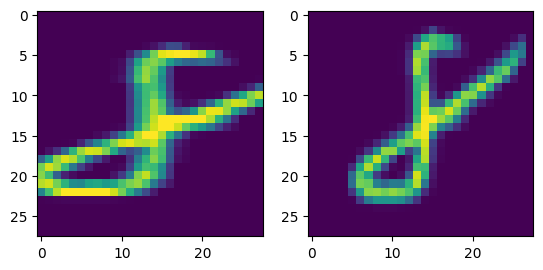

In [185]:
i = 1707
plt.subplot(1,2,1)
plt.imshow(transforms.CenterCrop(28)(transforms.Resize((28,56))(pu_dataset.__getitem__(i)[0])))
# plt.imshow(transforms.RandomResizedCrop(21, scale=(0.5, 0.8))(pu_dataset.__getitem__(i)[0]))
plt.subplot(1,2,2)
# plt.imshow(pu_dataset.__getitem__(i)[0])
plt.imshow(transforms.RandomResizedCrop(28, scale=(0.8, 1.0))(pu_dataset.__getitem__(i)[0]))

/tmp/ipykernel_1951/2500504902.py:2: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  noraml_sample_1 = random.sample(set(pu_dataset_normal_indices) - set(sub_normal_list), 10)
/tmp/ipykernel_1951/2500504902.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  noraml_sample_2 = random.sample(set(sub_normal_list), 10)


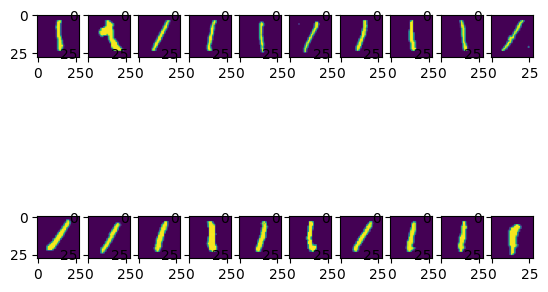

In [308]:
import random
noraml_sample_1 = random.sample(set(pu_dataset_normal_indices) - set(sub_normal_list), 10)
noraml_sample_2 = random.sample(set(sub_normal_list), 10)
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(pu_dataset.__getitem__(noraml_sample_1[i])[0])
    plt.subplot(2,10,10+i+1)
    plt.imshow(pu_dataset.__getitem__(noraml_sample_2[i])[0])


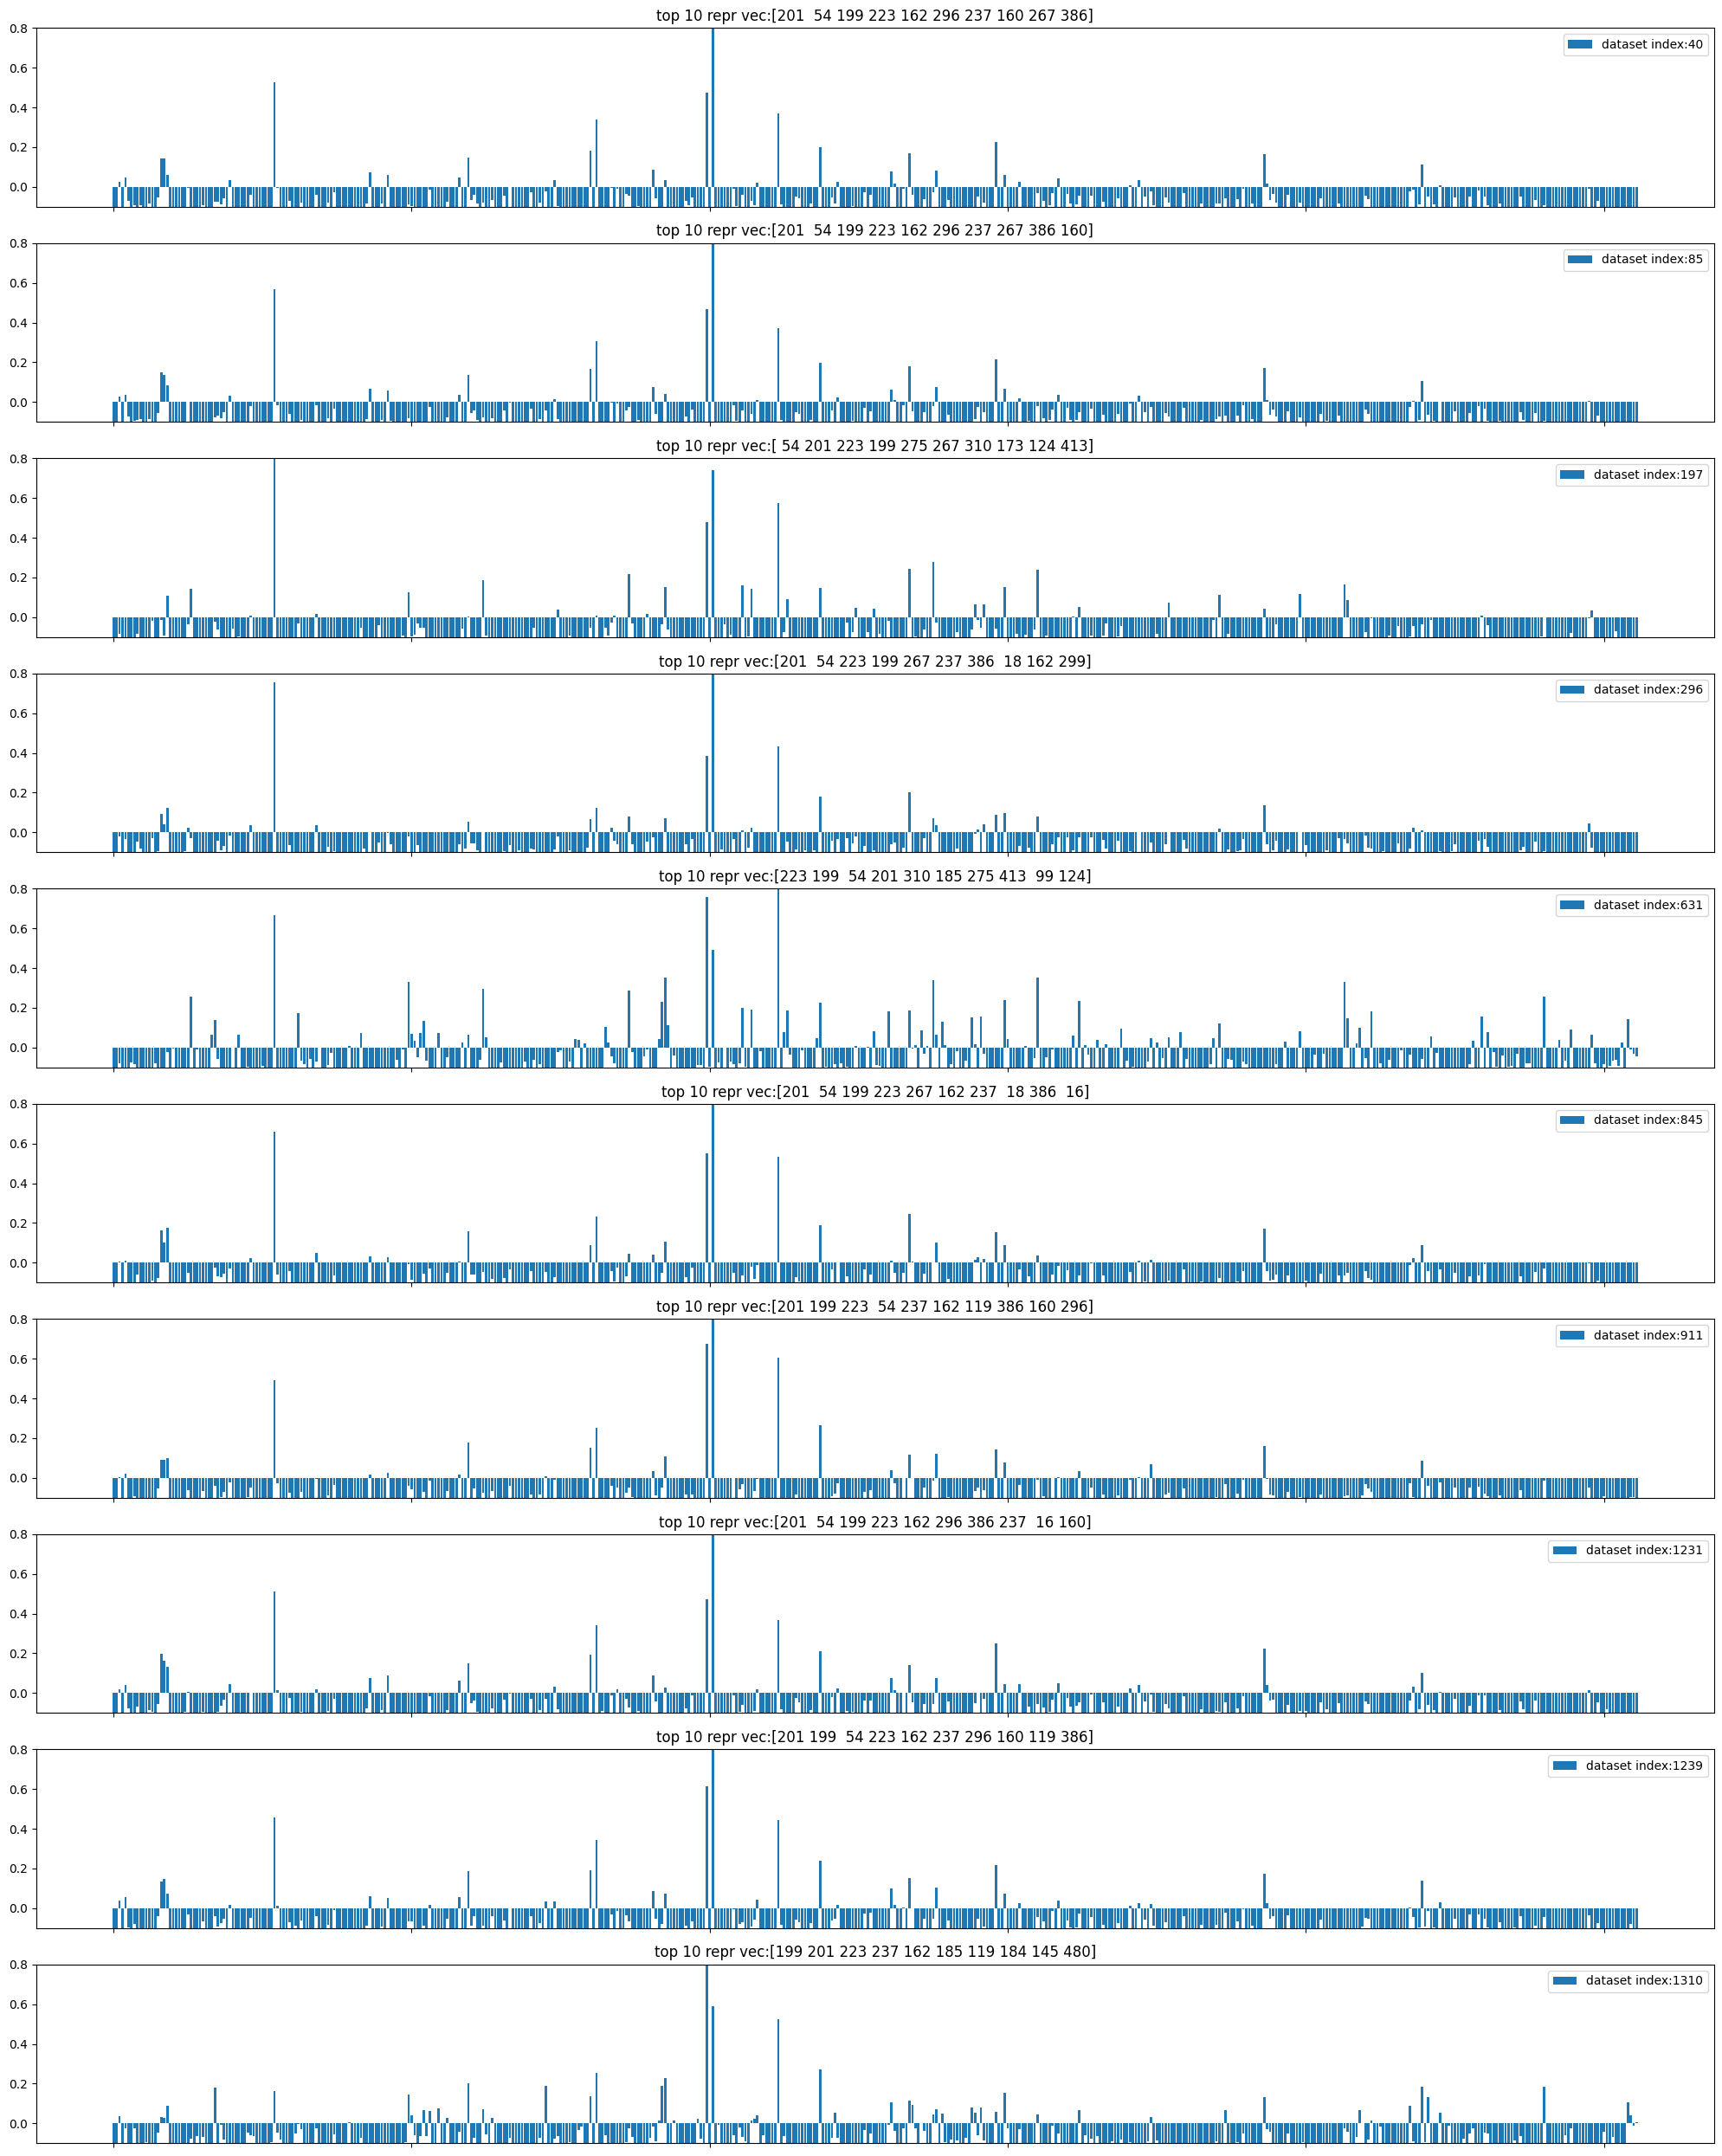

In [602]:
pu_dataset_normal_indices = (pu_dataset_targets==1).nonzero()[0]
repr_vec_list=[]
unl_sub_repr = defaultdict(float)

sub_normal_list = []

plt.figure(figsize=(20,25))
plot_n = 0
for n, tar_id in enumerate(pu_dataset_normal_indices):
    sample_img, sample_id = pu_dataset.__getitem__(tar_id)
    sample_img = torch.unsqueeze(sample_img,0).cuda(non_blocking=True)
    with torch.no_grad():
        output = teacher(sample_img)[0][0]
    output =  output.cpu().detach().numpy()
    repr_vec = np.argsort(output)[::-1][:20]
    # if 6 in repr_vec[:5]: continue
    if 369 in repr_vec[:5]: 
        print(tar_id)
        continue
    repr_vec_list.append(repr_vec)
    for arg in repr_vec[:5]:
        unl_sub_repr[arg] += output[arg]
    sub_normal_list.append(tar_id)

    # output =  output.cpu().detach()
    # sorted_out, sorted_arg = torch.sort(output, descending=True)
    # sorted_out, sorted_arg = sorted_out.numpy()[:5], sorted_arg.numpy()[:5]
    # for out, arg in zip(sorted_out, sorted_arg):
    #     normal_vec_dict[arg] += out #ths_proj(out)
    
    if np.random.random() < 0.2 and plot_n <10:
        plot_n += 1
        plt.subplot(10, 1, plot_n)
        plt.bar(list(range(len(output)))[:], output[:], label=f"dataset index:{tar_id}")
        plt.ylim([-0.1, 0.8])
        plt.legend()
        plt.title(f"top 10 repr vec:{str(repr_vec[:10])}")
        plt.tick_params(labelbottom=False)
        # plt.xticks(np.arange(0,2000, 100), np.arange(0,2000, 100), fontsize = 20)
plt.tight_layout()

In [605]:
Counter(np.concatenate(repr_vec_list))

Counter({223: 229,
         199: 229,
         201: 229,
         54: 229,
         237: 223,
         267: 202,
         299: 198,
         185: 187,
         119: 186,
         310: 155,
         276: 145,
         99: 141,
         162: 134,
         480: 132,
         275: 121,
         439: 121,
         184: 116,
         173: 114,
         386: 113,
         160: 110,
         18: 96,
         124: 92,
         34: 85,
         324: 83,
         413: 83,
         296: 82,
         16: 73,
         17: 66,
         211: 47,
         181: 44,
         86: 44,
         26: 42,
         348: 39,
         414: 39,
         508: 38,
         261: 36,
         92: 33,
         145: 30,
         268: 22,
         214: 22,
         291: 17,
         104: 14,
         398: 14,
         422: 13,
         354: 10,
         289: 10,
         371: 10,
         116: 10,
         292: 9,
         441: 9,
         226: 9,
         459: 7,
         496: 6,
         369: 4,
         68: 4,
       

In [571]:
pu_dataset_normal_indices

array([   7,    9,   17,   24,   25,   40,   43,   57,   85,  153,  197,
        219,  241,  264,  294,  296,  361,  366,  370,  382,  445,  535,
        569,  587,  588,  631,  803,  804,  818,  821,  845,  879,  884,
        911,  954,  956,  992,  993, 1000, 1010, 1013, 1044, 1108, 1111,
       1112, 1138, 1153, 1159, 1177, 1183, 1186, 1204, 1209, 1222, 1231,
       1238, 1239, 1252, 1271, 1273, 1276, 1310, 1358, 1383, 1413, 1423,
       1425, 1431, 1462, 1473, 1474, 1479, 1493, 1505, 1516, 1517, 1522,
       1528, 1559, 1586, 1616, 1623, 1648, 1678, 1700, 1701, 1704, 1724,
       1758, 1772, 1776, 1798, 1804, 1833, 1862, 1863, 1867, 1870, 1876,
       1896, 1911, 1922, 1933, 1939, 1961, 1968, 1983, 1986, 2096, 2141,
       2148, 2158, 2172, 2185, 2201, 2229, 2236, 2259, 2260, 2285, 2286,
       2301, 2309, 2341, 2343, 2345, 2350, 2388, 2390, 2395, 2405, 2449,
       2475, 2476, 2513, 2521, 2548, 2570, 2592, 2648, 2686, 2688, 2712,
       2746, 2756, 2824, 2840, 2865, 2908, 2940, 29

In [555]:
print(*unl_sub_repr, sep="\n")
unl_sub_repr = {k:v for k,v in unl_sub_repr.items() if not k in pos_repr_vec_indices}
unl_sub_repr = dict(sorted(unl_sub_repr.items(), key=lambda x:x[1], reverse=True))
print(len(unl_sub_repr))
print(*unl_sub_repr.items(), sep="\n")

201
199
223
54
237
185
162
267
275
414
413
18
310
184
324
10
(185, 18.730984419584274)
(162, 18.358224272727966)
(267, 4.952787175774574)
(275, 4.945493102073669)
(414, 0.9557768702507019)
(413, 0.62265944480896)
(18, 0.47903957962989807)
(310, 0.3516504764556885)
(184, 0.2967448830604553)
(324, 0.2821671664714813)


In [554]:
#ラベルありデータの上位代表ベクトル
# 1738: 0.92292
# 1757: 0.31854
### 6: 0.18047
# 1578: 0.05902
# 8: 0.16381
# 1284: 0.10104
pos_repr_vec_indices = [1738, 1757, 1578, 8, 1284]
pos_repr_vec_indices = [201, 199, 223, 54, 237]


In [556]:
unl_sub_pos_repr_vec_list = [np.delete(l, np.where(np.isin(l, pos_repr_vec_indices))[0]) for l in repr_vec_list]
Counter(np.concatenate(unl_sub_pos_repr_vec_list))

Counter({267: 202,
         299: 198,
         185: 187,
         119: 186,
         310: 155,
         276: 145,
         99: 141,
         162: 134,
         480: 132,
         275: 121,
         439: 121,
         184: 116,
         173: 114,
         386: 113,
         160: 110,
         18: 96,
         124: 92,
         34: 85,
         324: 83,
         413: 83,
         296: 82,
         16: 73,
         17: 66,
         211: 47,
         181: 44,
         86: 44,
         26: 42,
         348: 39,
         414: 39,
         508: 38,
         261: 36,
         92: 33,
         145: 30,
         268: 22,
         214: 22,
         291: 17,
         104: 14,
         398: 14,
         422: 13,
         354: 10,
         289: 10,
         371: 10,
         116: 10,
         292: 9,
         441: 9,
         226: 9,
         459: 7,
         496: 6,
         369: 4,
         68: 4,
         186: 4,
         46: 3,
         495: 2,
         288: 2,
         290: 2,
         167: 2,


In [566]:
# del teacher.head.last_layer
#正常データのサブ代表ベクトル
sub_normal_repr_vec_indices = [280, 1413, 696]
sub_normal_repr_vec_indices = [267, 299, 185]

sub_noraml_repr_vec = {}

for i in sub_normal_repr_vec_indices:
    w = head_state["last_layer.weight_v"][i,:]
    sub_noraml_repr_vec[i] = w / torch.norm(w, p=2)

#正常データのindex 
normal_indices = (val_dataset.targets==1).nonzero().flatten()
#異常データのindex
anomaly_indices = (val_dataset.targets!=1).nonzero().flatten()

#結果の配列
y_true = []
sub_y_score_1 = []

vec = sub_noraml_repr_vec[185]
 
for i in range(len(val_dataset)):
    if i in normal_indices:
        y_true.append(0)
    elif i in anomaly_indices:
        y_true.append(1)    
    sample = val_dataset.__getitem__(i)[0]
    sample = sample.unsqueeze(0)
    with torch.no_grad():
        head_emb = teacher(sample.cuda(non_blocking=True))[0].cpu()
    head_emb = nn.functional.normalize(head_emb.unsqueeze(0), p=2)[0]
    sub_y_score_1.append(((vec @ head_emb).item()))

sub_y_score_1 = np.array(sub_y_score_1)
sub_y_score_1 = (sub_y_score_1 - sub_y_score_1.min()) / (sub_y_score_1.max() - sub_y_score_1.min())
sub_y_score_1 = 1- sub_y_score_1

In [558]:
#正常 0 異常 1
k = 0
flag=0
for n, (t, s, s_s) in enumerate(zip(y_true, y_score, sub_y_score_1)):
    if n < 200: continue

    if flag == t:
        print(f"{t}, {s:.5f}, {s_s:.5f}")
        k += 1
        flag = -flag+1    

    # if t == 0:# and s > 0.5:
    #     print(f"{t}, {s:.5f}, {s_s:.5f}")
    #     k += 1
    if k == 30: break
#sが大きい->w1との類似度が低い, s_sが小さい->sub w1との類似度が大きい

0, 0.77389, 0.52116
1, 0.66761, 0.35082
0, 0.73793, 0.59554
1, 0.89393, 0.36377
0, 0.69276, 0.45149
1, 0.87341, 0.27324
0, 0.01610, 0.95399
1, 0.72794, 0.35078
0, 0.17647, 0.90242
1, 0.77133, 0.33391
0, 0.12992, 0.61907
1, 0.82600, 0.24064
0, 0.22002, 0.46706
1, 0.80881, 0.37844
0, 0.02557, 0.95246
1, 0.88066, 0.30401
0, 0.25822, 0.50391
1, 0.72418, 0.25486
0, 0.14401, 0.92578
1, 0.81172, 0.30343
0, 0.25561, 0.59148
1, 0.60078, 0.44693
0, 0.00993, 0.93966
1, 0.78454, 0.33135
0, 0.06774, 0.76307
1, 0.85991, 0.34979
0, 0.22679, 0.48787
1, 0.88752, 0.29556
0, 0.13649, 0.70060
1, 0.83326, 0.34650


In [562]:
y_score_enh_by_1 = np.copy(y_score)
enh_id = (y_score_enh_by_1 > 0.7) & (sub_y_score_1 < 0.3)
y_score_enh_by_1[enh_id] = y_score_enh_by_1[enh_id] - sub_y_score_1[enh_id]

In [560]:
np.shares_memory(y_score_enh_by_1, y_score)

False

0.8700890747407889
0.7982571663548429


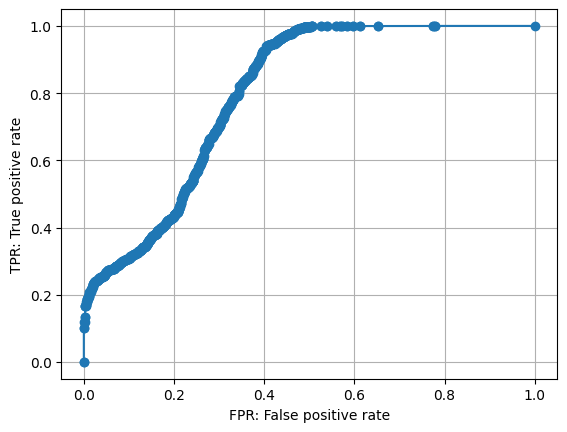

In [564]:
fpr, tpr, thresholds = roc_curve(y_true, y_score_enh_by_1)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
print(roc_auc_score(y_true, y_score))
print(roc_auc_score(y_true, y_score_enh_by_1))

In [165]:
normal_repr_vec = head_state["last_layer.weight_v"][6,:]
normal_repr_vec /= torch.norm(normal_repr_vec, p=2)
normal_repr_vec.shape

torch.Size([256])

In [105]:
normal_indices = (val_dataset.targets==1).nonzero().flatten()
normal_indices

tensor([   2,    5,   14,  ..., 9978, 9984, 9994])

In [185]:
normal_sample = val_dataset.__getitem__(5)[0]
normal_sample = normal_sample.unsqueeze(0)
normal_sample.shape

torch.Size([1, 1, 28, 28])

In [186]:
# del teacher.head.last_layer
with torch.no_grad():
    normal_head_emb = teacher(normal_sample.cuda(non_blocking=True))[0].cpu()
normal_head_emb = nn.functional.normalize(normal_head_emb.unsqueeze(0), p=2)[0]

normal_head_emb.shape
# normal_sample = nn.functional.normalize(normal_sample, p=2)
# normal_sample /= torch.norm(normal_sample, p=2)

torch.Size([256])

In [187]:
torch.norm(normal_repr_vec, p=2), torch.norm(normal_head_emb, p=2)

(tensor(1.), tensor(1.))

In [195]:
(normal_repr_vec @ normal_head_emb).item()

0.8343497514724731